In [1]:
import os
import random

import torch
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime

from tqdm import tqdm   # show loops progress

In [2]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version from PyTorch: {torch.version.cuda}")

PyTorch version: 2.5.1
CUDA version from PyTorch: 12.1


In [3]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce RTX 4070 Ti SUPER


**SEED**

In [4]:
SEED:int = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

**LOAD TRAIN DATA**

In [5]:
# Dataset personalizado para DRIVE
class Dataset(Dataset):
    def __init__(self, image_dir, ground_truth, transform=None, transform_img=None):
        self.image_dir = image_dir
        self.ground_truth_dir = ground_truth
        self.image_filenames = os.listdir(image_dir)  
        self.mask_filenames = os.listdir(ground_truth)   
        self.transform = transform
        self.transform_img = transform_img

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        ground_truth_path = os.path.join(self.ground_truth_dir, self.mask_filenames[idx])
        
        image = Image.open(image_path).convert('RGB')
        ground_truth = Image.open(ground_truth_path).convert('L')  # gt to grayscale
        
        # image to tensor (needed to concatenate and more)
        image = transforms.ToTensor()(image)
        ground_truth = transforms.ToTensor()(ground_truth)
        
        if self.transform:        # exactly same transformations to image and gt
            # Concatenate along channel dimension.
            # Here, dim=0 is the channel dimension (not the batch dim) (here we have [C, H, W])
            image_and_gt = torch.cat([image, ground_truth], dim=0) 
            
            # Transform together
            transformed = self.transform(image_and_gt)

            # Slice the tensors out
            image = transformed[:3, :, :]    
            ground_truth = (transformed[3:, :, :] > 0.5).float()       # binarize !!!
        
        
        if self.transform_img:       # transformations only for images
            image = self.transform_img(image)
            

        return image, ground_truth, self.image_filenames[idx]

In [6]:
# Routes for training data
image_dir = './data/CHASE/training/images'
ground_truth_dir = './data/CHASE/training/1st_manual'

''' # Just compute the mean and std
from torchvision import datasets
# calculate mean and std
dataset = Dataset(image_dir, ground_truth_dir, transform=transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

NORM_MEAN = 0.
NORM_STD = 0.
for images, _, _ in dataloader:
    NORM_MEAN += images.mean([0, 2, 3])  # channels means (R, G, B)
    NORM_STD += images.std([0, 2, 3])    # channels std

NORM_MEAN /= len(dataloader)
NORM_STD /= len(dataloader)

print(f"Mean: {NORM_MEAN}")
print(f"Std: {NORM_STD}")'''

' # Just compute the mean and std\nfrom torchvision import datasets\n# calculate mean and std\ndataset = Dataset(image_dir, ground_truth_dir, transform=transforms.ToTensor())\ndataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)\n\nNORM_MEAN = 0.\nNORM_STD = 0.\nfor images, _, _ in dataloader:\n    NORM_MEAN += images.mean([0, 2, 3])  # channels means (R, G, B)\n    NORM_STD += images.std([0, 2, 3])    # channels std\n\nNORM_MEAN /= len(dataloader)\nNORM_STD /= len(dataloader)\n\nprint(f"Mean: {NORM_MEAN}")\nprint(f"Std: {NORM_STD}")'

In [7]:
IMG_SIZE:int = 512
DATA_AUG_PROB:float = 0.85

from torchvision.transforms import v2

# transforms for images and its ground truth segmentations (same for both)
transform = v2.Compose([
    v2.RandomApply([
        v2.RandomHorizontalFlip(),
        v2.RandomVerticalFlip(),
        #v2.RandomZoomOut(fill=0, p=0.2), 
        v2.RandomAffine(degrees=(-180, 180), translate=(0.1, 0.1), scale=(0.5, 1.5)),
        #v2.RandomResizedCrop(IMG_SIZE),
        #v2.ElasticTransform(alpha=15.0),
        #v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
        
    ], p=DATA_AUG_PROB),
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    
    # transforms.Grayscale(num_output_channels=1),       # we want rgb    
    #transforms.ToTensor(),             # already tensors
    #transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),   # no
    
])

# transform just for the image
transform_img = v2.Compose([
    v2.RandomApply([
        v2.ColorJitter(brightness=[0.6, 1.2], contrast=[0.3, 1.3], saturation=[0.5, 1.3], hue=0.015),
        v2.RandomAdjustSharpness(sharpness_factor=1.5),
        #v2.GaussianNoise(),

    ], p=DATA_AUG_PROB),
     
    #transforms.ToTensor(),             # already tensors
    #transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),   # no
    
])


dataset = Dataset(image_dir, ground_truth_dir, transform=transform, transform_img=transform_img)

In [8]:
example_loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)
for img, gt, _ in example_loader:
    print(img.shape)
    print(gt.shape)
    print("\n")
    break

torch.Size([8, 3, 512, 512])
torch.Size([8, 1, 512, 512])




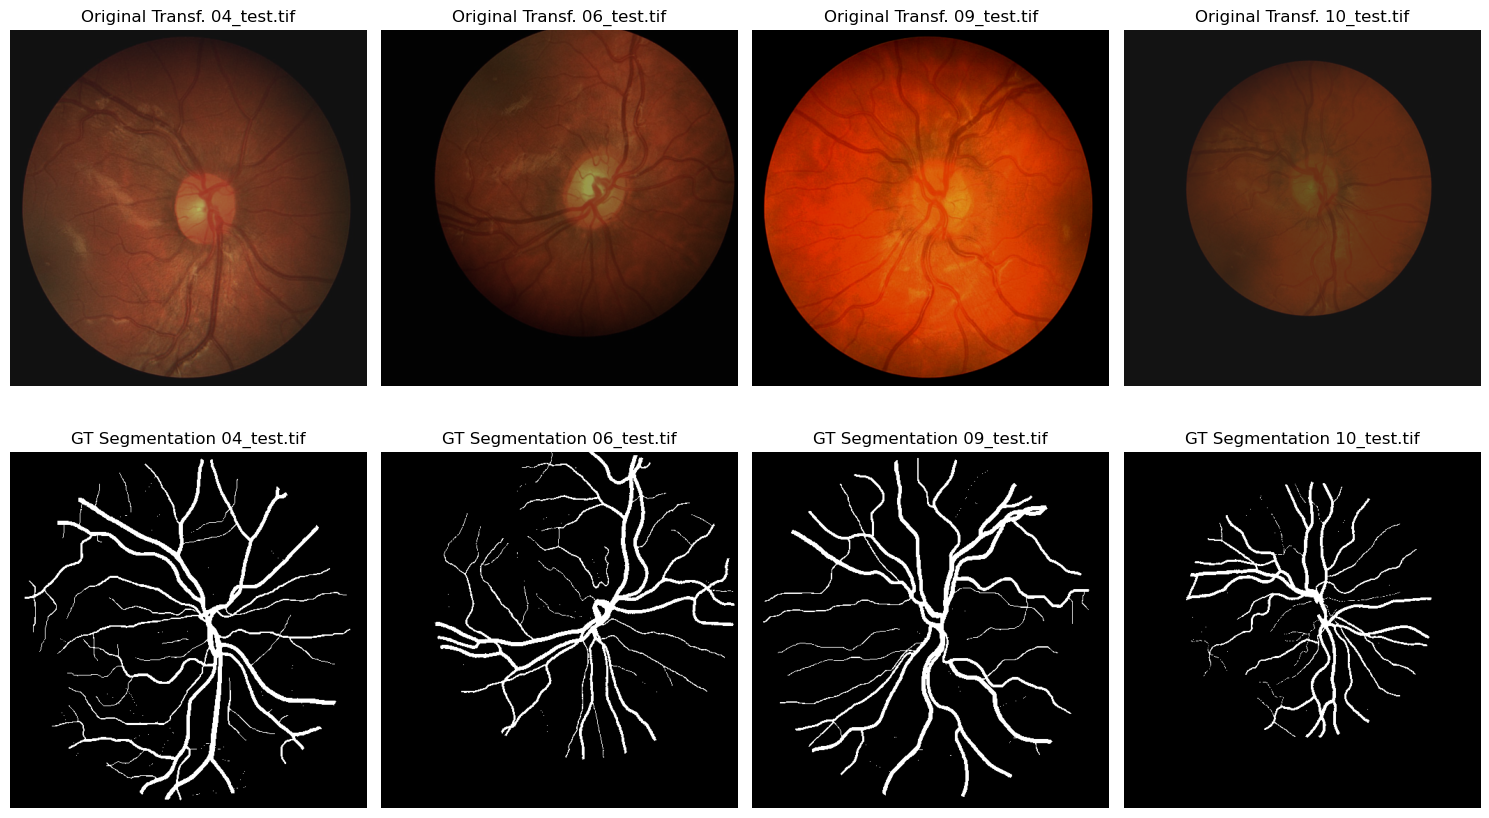

In [9]:
example_loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)

# Obtener algunas imágenes y máscaras del example_loader
data_iter = iter(example_loader)
images, ground_truth, img_name = next(data_iter)

# Convertir los tensores a formato numpy para visualizarlos
images = images.numpy().transpose(0, 2, 3, 1)  # [N, C, H, W] a [N, H, W, C]
ground_truth = ground_truth.numpy()  # [N, H, W] para las máscaras

# Eliminar la dimensión extra (1, H, W) de las máscaras
ground_truth = np.squeeze(ground_truth)  # Esto convierte la forma (1, H, W) a (H, W)

# Visualizar las imágenes en la fila superior y las máscaras en la fila inferior
fig, axes = plt.subplots(2, 4, figsize=(15, 9))  # 2 filas, 4 columnas (imágenes arriba y máscaras abajo)

for i in range(4):
    # Mostrar la imagen en la fila superior
    axes[0, i].imshow(images[i])
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Original Transf. {img_name[i]}')
    
    # Mostrar la máscara en la fila inferior
    axes[1, i].imshow(ground_truth[i], cmap='gray')  # show as grayscale
    axes[1, i].axis('off')
    axes[1, i].set_title(f'GT Segmentation {img_name[i]}')

plt.tight_layout()
plt.show()

**DATA SPLITTING**

In [10]:
VAL_PERCENT:float = 0.2            # Percentage of dataset intended for validation (rest is for training) 
BATCH_SIZE:int = 4

# Split into train / validation partitions
val_size = int(len(dataset) * VAL_PERCENT)     # number of samples for validation
train_size = len(dataset) - val_size           # number of samples for training
train_set, val_set = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

print('Training set has {} instances'.format(train_size))
print('Validation set has {} instances'.format(val_size))

Training set has 16 instances
Validation set has 4 instances


In [11]:
sample_image, sample_gt, _ = train_set[0]

NUM_CHANNELS_IN:int = sample_image.size(0)  
NUM_CHANNELS_OUT:int = sample_gt.size(0)

print(f"Number of channels in input: {NUM_CHANNELS_IN}")
print(f"Number of channels in output: {NUM_CHANNELS_OUT}")

Number of channels in input: 3
Number of channels in output: 1


**CREATE MODEL**

In [12]:
from unet import UNet
model = UNet(n_channels=NUM_CHANNELS_IN, n_classes=NUM_CHANNELS_OUT)

# cuda if available, cpu if not
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device.type=}")
model.to(device)      # move to cuda if possible

#from torchsummary import summary
#summary(model, (NUM_CHANNELS_IN, IMG_SIZE, IMG_SIZE))

device.type='cuda'


UNet(
  (inp): InputBlock(
    (conv): Block(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): EncoderBlock(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Block(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (4): BatchNorm2d(128, e

**SOME HYPERPARAMETERS, SAVE PATH, CUDA**

In [13]:
EPOCHS:int = 1000

# save best model state path
SAVE_PATH = "./trained_models"
       

# LOSS FUNCTION -----------------------------------------------------
from utils.loss_functions import DiceLoss, DiceBCELoss, DiceBCELossWithTopology
#(need sigmoid at the end of network)

#loss_fn = torch.nn.BCELoss()        # binary cross-entropy loss 
#loss_fn = DiceLoss()
loss_fn = DiceBCELoss(bce_weight=0.5)      # weight of BCE
#loss_fn = DiceBCELossWithTopology(bce_weight=0.5, topology_weight=0.5, image_pixels=IMG_SIZE*IMG_SIZE)


# OPTIMIZER ---------------------------------------------------------
LEARNING_RATE:float = 0.001
MOMENTUM:float = 0.9
WEIGHT_DECAY:float = 1e-2

#optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

optimizer = torch.optim.AdamW([
    {'params': model.parameters()},  # Parámetros del modelo
    {'params': loss_fn.parameters()}  # Parámetros de la pérdida
], lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

**TRAIN FUNCTION**

In [14]:
def training_loop(epochs, model, train_dataloader, val_dataloader, 
                  loss_fn, optimizer, save_path, patience=30):
    
    history = {'train_loss': [], 'val_loss': [], 'train_accuracy':[], 'val_accuracy':[]}
    best_val_loss = float('inf')  # Initialize to infinity
    best_model_state = None
    datetime_start = datetime.now()
    
    early_stopping_counter = 0  # Counter for early stopping

    for epoch in range(1, epochs+1):
        model.train()
        running_train_loss = 0
        train_correct_pred = 0
        total_train_pred = 0
        
        for data in tqdm(train_dataloader):      # for each training batch
            
            img, ground_truth, _ = data
            img, ground_truth = img.to(device), ground_truth.to(device)     # move to cuda, if possible
            
            pred = model(img)
            # print(f"Pred shape: {pred.shape}, Ground truth shape: {ground_truth.shape}")   # debug
            # print(torch.max(pred))
            # print(torch.min(pred))
            # print(f"Pred device: {pred.device}, Ground truth device: {ground_truth.device}")
            # print(f"Pred type: {type(pred)}")
            # print(f"Pred content: {pred}")

            # print(f"Ground truth values: {ground_truth.unique()}")
            # print("\n")

            loss = loss_fn(pred, ground_truth)
            # print(loss)
            # print(loss.shape)
            running_train_loss += loss.item()
            train_correct_pred += ((pred > 0.5).float() == ground_truth).sum()      # add number of correct predictions
            total_train_pred += IMG_SIZE*IMG_SIZE*len(img)            # add number of predictions made (pixels per img * number of imgs)
            
            loss.backward()            # calculate gradients
            optimizer.step()           # update model parameters
            optimizer.zero_grad()      # reset gradients
        
        model.eval()
        with torch.no_grad():
            running_val_loss = 0
            val_correct_pred = 0
            total_val_pred = 0
            
            for data in tqdm(val_dataloader):      # for each validation batch
                
                img, ground_truth, _ = data
                img, ground_truth = img.to(device), ground_truth.to(device)       # move to cuda, if possible
                
                pred = model(img)
                loss = loss_fn(pred, ground_truth)
                
                running_val_loss += loss.item()
                val_correct_pred += ((pred > 0.5).float() == ground_truth).sum()         # add number of correct predictions
                total_val_pred += IMG_SIZE*IMG_SIZE*len(img)                     # add number of predictions made (pixels per img * number of imgs)


        train_loss = running_train_loss / len(train_dataloader.dataset)
        val_loss = running_val_loss / len(val_dataloader.dataset)
        train_acc = train_correct_pred / total_train_pred * 100       # % of average accuracy in training, in this epoch
        val_acc = val_correct_pred / total_val_pred * 100             # % of average accuracy in validation, in this epoch

        history['train_loss'].append(train_loss)         # add metrics in this epoch to the record
        history['val_loss'].append(val_loss)
        history['train_accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
        
        print(f'Epoch: {epoch}/{epochs} | Training loss: {train_loss:.5f} | Validation loss: {val_loss:.5f} | Training accuracy: {train_acc:.2f}% | Validation accuracy: {val_acc:.2f}%')
        print(f"\n")
        
        # Save the model if the validation loss improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()  # Save the model state
            early_stopping_counter = 0   # Reset counter if validation loss improves
        else:
            early_stopping_counter += 1
            print(f"Validation loss did not improve. Early stopping counter: {early_stopping_counter}/{patience}")
        
        # Stop training if patience is exceeded
        if early_stopping_counter >= patience:
            print("Early stopping triggered!")
            break
        
    # Save the best model state
    if best_model_state is not None:
        model_path = save_path + '/' + '{}_{}_{:.5f}'.format(datetime_start.strftime('%Y%m%d_%H%M%S'), type(model).__name__, best_val_loss)
        torch.save(best_model_state, model_path)    
        print(f'Best model saved at {model_path}')
    
    # save history (dictionary)
    history_path = save_path + '/' + '{}_{}_{:.5f}'.format(datetime_start.strftime('%Y%m%d_%H%M%S'), type(model).__name__, best_val_loss)+'_history'
    torch.save(history, history_path)
    print(f'\nHistory saved at {history_path}')
    
    model.eval()
    return history

In [15]:
# TRAIN THE CURRENT MODEL
start_time = datetime.now()

PATIENCE = 100

history = training_loop(EPOCHS, model, train_loader, val_loader, 
                        loss_fn, optimizer, SAVE_PATH, PATIENCE)

end_time = datetime.now()
print(f"\nTraining duration: {end_time - start_time}")

100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


Epoch: 1/1000 | Training loss: 0.27714 | Validation loss: 0.30452 | Training accuracy: 80.21% | Validation accuracy: 94.07%




100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


Epoch: 2/1000 | Training loss: 0.26577 | Validation loss: 0.30250 | Training accuracy: 87.27% | Validation accuracy: 95.19%




100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Epoch: 3/1000 | Training loss: 0.24562 | Validation loss: 0.28298 | Training accuracy: 87.08% | Validation accuracy: 93.27%




100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Epoch: 4/1000 | Training loss: 0.24074 | Validation loss: 0.26839 | Training accuracy: 88.08% | Validation accuracy: 91.32%




100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


Epoch: 5/1000 | Training loss: 0.22124 | Validation loss: 0.36831 | Training accuracy: 91.38% | Validation accuracy: 62.38%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch: 6/1000 | Training loss: 0.21389 | Validation loss: 0.25976 | Training accuracy: 91.79% | Validation accuracy: 83.97%




100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch: 7/1000 | Training loss: 0.19780 | Validation loss: 0.27779 | Training accuracy: 92.33% | Validation accuracy: 92.40%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Epoch: 8/1000 | Training loss: 0.19967 | Validation loss: 0.25278 | Training accuracy: 92.47% | Validation accuracy: 89.99%




100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Epoch: 9/1000 | Training loss: 0.18657 | Validation loss: 0.24594 | Training accuracy: 92.53% | Validation accuracy: 91.58%




100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Epoch: 10/1000 | Training loss: 0.18546 | Validation loss: 0.31188 | Training accuracy: 94.71% | Validation accuracy: 54.50%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 11/1000 | Training loss: 0.17464 | Validation loss: 0.21512 | Training accuracy: 93.25% | Validation accuracy: 92.90%




100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch: 12/1000 | Training loss: 0.17245 | Validation loss: 0.22333 | Training accuracy: 92.66% | Validation accuracy: 94.14%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch: 13/1000 | Training loss: 0.16833 | Validation loss: 0.23828 | Training accuracy: 94.74% | Validation accuracy: 93.89%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch: 14/1000 | Training loss: 0.16070 | Validation loss: 0.18597 | Training accuracy: 93.59% | Validation accuracy: 93.59%




100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Epoch: 15/1000 | Training loss: 0.15667 | Validation loss: 0.24013 | Training accuracy: 93.48% | Validation accuracy: 93.64%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 16/1000 | Training loss: 0.15892 | Validation loss: 0.21011 | Training accuracy: 93.37% | Validation accuracy: 93.16%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch: 17/1000 | Training loss: 0.15595 | Validation loss: 0.21167 | Training accuracy: 93.70% | Validation accuracy: 93.25%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch: 18/1000 | Training loss: 0.14808 | Validation loss: 0.21020 | Training accuracy: 94.69% | Validation accuracy: 87.43%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch: 19/1000 | Training loss: 0.15213 | Validation loss: 0.15821 | Training accuracy: 92.91% | Validation accuracy: 95.73%




100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch: 20/1000 | Training loss: 0.14287 | Validation loss: 0.17616 | Training accuracy: 94.26% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch: 21/1000 | Training loss: 0.13513 | Validation loss: 0.15207 | Training accuracy: 94.75% | Validation accuracy: 95.01%




100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 22/1000 | Training loss: 0.12865 | Validation loss: 0.14024 | Training accuracy: 95.69% | Validation accuracy: 95.26%




100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch: 23/1000 | Training loss: 0.12503 | Validation loss: 0.14502 | Training accuracy: 95.47% | Validation accuracy: 95.07%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch: 24/1000 | Training loss: 0.12222 | Validation loss: 0.13054 | Training accuracy: 95.47% | Validation accuracy: 96.00%




100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 25/1000 | Training loss: 0.12060 | Validation loss: 0.14310 | Training accuracy: 94.99% | Validation accuracy: 95.00%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch: 26/1000 | Training loss: 0.12479 | Validation loss: 0.11338 | Training accuracy: 95.43% | Validation accuracy: 96.94%




100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch: 27/1000 | Training loss: 0.11386 | Validation loss: 0.12570 | Training accuracy: 95.18% | Validation accuracy: 93.65%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch: 28/1000 | Training loss: 0.11218 | Validation loss: 0.13166 | Training accuracy: 94.78% | Validation accuracy: 95.22%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch: 29/1000 | Training loss: 0.11443 | Validation loss: 0.14374 | Training accuracy: 94.61% | Validation accuracy: 95.52%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch: 30/1000 | Training loss: 0.12202 | Validation loss: 0.12694 | Training accuracy: 95.49% | Validation accuracy: 97.61%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 31/1000 | Training loss: 0.11060 | Validation loss: 0.11102 | Training accuracy: 95.57% | Validation accuracy: 97.99%




100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch: 32/1000 | Training loss: 0.10895 | Validation loss: 0.12988 | Training accuracy: 95.99% | Validation accuracy: 94.96%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch: 33/1000 | Training loss: 0.10939 | Validation loss: 0.10174 | Training accuracy: 95.15% | Validation accuracy: 95.91%




100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch: 34/1000 | Training loss: 0.10347 | Validation loss: 0.10276 | Training accuracy: 95.26% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch: 35/1000 | Training loss: 0.10682 | Validation loss: 0.11320 | Training accuracy: 96.37% | Validation accuracy: 95.49%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 36/1000 | Training loss: 0.09890 | Validation loss: 0.10120 | Training accuracy: 96.02% | Validation accuracy: 94.91%




100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch: 37/1000 | Training loss: 0.09521 | Validation loss: 0.11667 | Training accuracy: 95.66% | Validation accuracy: 97.17%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch: 38/1000 | Training loss: 0.10059 | Validation loss: 0.09880 | Training accuracy: 96.27% | Validation accuracy: 96.71%




100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 39/1000 | Training loss: 0.09568 | Validation loss: 0.11231 | Training accuracy: 96.69% | Validation accuracy: 96.05%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch: 40/1000 | Training loss: 0.09916 | Validation loss: 0.10623 | Training accuracy: 96.59% | Validation accuracy: 96.65%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch: 41/1000 | Training loss: 0.09391 | Validation loss: 0.14559 | Training accuracy: 96.86% | Validation accuracy: 94.97%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 42/1000 | Training loss: 0.09514 | Validation loss: 0.09941 | Training accuracy: 96.12% | Validation accuracy: 95.92%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch: 43/1000 | Training loss: 0.09831 | Validation loss: 0.11594 | Training accuracy: 96.03% | Validation accuracy: 95.75%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 44/1000 | Training loss: 0.09042 | Validation loss: 0.10677 | Training accuracy: 96.46% | Validation accuracy: 95.80%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 45/1000 | Training loss: 0.09343 | Validation loss: 0.09797 | Training accuracy: 96.17% | Validation accuracy: 95.63%




100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch: 46/1000 | Training loss: 0.09135 | Validation loss: 0.09819 | Training accuracy: 96.42% | Validation accuracy: 95.31%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch: 47/1000 | Training loss: 0.09141 | Validation loss: 0.11672 | Training accuracy: 96.05% | Validation accuracy: 94.86%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch: 48/1000 | Training loss: 0.09134 | Validation loss: 0.11898 | Training accuracy: 96.26% | Validation accuracy: 97.18%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch: 49/1000 | Training loss: 0.09191 | Validation loss: 0.10405 | Training accuracy: 96.35% | Validation accuracy: 94.91%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch: 50/1000 | Training loss: 0.09065 | Validation loss: 0.09586 | Training accuracy: 96.11% | Validation accuracy: 96.39%




100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch: 51/1000 | Training loss: 0.08766 | Validation loss: 0.09438 | Training accuracy: 96.11% | Validation accuracy: 98.07%




100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch: 52/1000 | Training loss: 0.08664 | Validation loss: 0.09230 | Training accuracy: 96.34% | Validation accuracy: 96.76%




100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch: 53/1000 | Training loss: 0.08311 | Validation loss: 0.08804 | Training accuracy: 96.41% | Validation accuracy: 97.51%




100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 54/1000 | Training loss: 0.08110 | Validation loss: 0.08369 | Training accuracy: 97.03% | Validation accuracy: 97.02%




100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch: 55/1000 | Training loss: 0.08270 | Validation loss: 0.08529 | Training accuracy: 96.51% | Validation accuracy: 96.44%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch: 56/1000 | Training loss: 0.08500 | Validation loss: 0.09996 | Training accuracy: 96.43% | Validation accuracy: 95.96%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 57/1000 | Training loss: 0.08508 | Validation loss: 0.10356 | Training accuracy: 96.45% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch: 58/1000 | Training loss: 0.09054 | Validation loss: 0.10340 | Training accuracy: 95.74% | Validation accuracy: 95.05%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 59/1000 | Training loss: 0.08583 | Validation loss: 0.09512 | Training accuracy: 96.41% | Validation accuracy: 96.32%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch: 60/1000 | Training loss: 0.08088 | Validation loss: 0.09373 | Training accuracy: 96.80% | Validation accuracy: 96.10%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch: 61/1000 | Training loss: 0.08784 | Validation loss: 0.09882 | Training accuracy: 96.07% | Validation accuracy: 96.00%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch: 62/1000 | Training loss: 0.08456 | Validation loss: 0.09505 | Training accuracy: 96.71% | Validation accuracy: 96.61%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch: 63/1000 | Training loss: 0.08960 | Validation loss: 0.09671 | Training accuracy: 95.72% | Validation accuracy: 95.86%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch: 64/1000 | Training loss: 0.08362 | Validation loss: 0.08584 | Training accuracy: 96.44% | Validation accuracy: 97.17%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 65/1000 | Training loss: 0.08014 | Validation loss: 0.08467 | Training accuracy: 96.42% | Validation accuracy: 97.64%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 66/1000 | Training loss: 0.08105 | Validation loss: 0.08646 | Training accuracy: 96.59% | Validation accuracy: 95.99%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch: 67/1000 | Training loss: 0.07744 | Validation loss: 0.08524 | Training accuracy: 96.90% | Validation accuracy: 96.06%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch: 68/1000 | Training loss: 0.07904 | Validation loss: 0.08999 | Training accuracy: 96.48% | Validation accuracy: 96.70%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch: 69/1000 | Training loss: 0.07919 | Validation loss: 0.08488 | Training accuracy: 96.67% | Validation accuracy: 96.36%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch: 70/1000 | Training loss: 0.07935 | Validation loss: 0.09268 | Training accuracy: 96.36% | Validation accuracy: 95.79%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch: 71/1000 | Training loss: 0.07658 | Validation loss: 0.08565 | Training accuracy: 96.83% | Validation accuracy: 97.30%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch: 72/1000 | Training loss: 0.07904 | Validation loss: 0.08432 | Training accuracy: 96.49% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 73/1000 | Training loss: 0.07680 | Validation loss: 0.07049 | Training accuracy: 96.93% | Validation accuracy: 97.88%




100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 74/1000 | Training loss: 0.07778 | Validation loss: 0.09157 | Training accuracy: 96.96% | Validation accuracy: 95.46%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


Epoch: 75/1000 | Training loss: 0.07670 | Validation loss: 0.08491 | Training accuracy: 97.13% | Validation accuracy: 96.50%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


Epoch: 76/1000 | Training loss: 0.08917 | Validation loss: 0.10877 | Training accuracy: 95.72% | Validation accuracy: 96.21%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Epoch: 77/1000 | Training loss: 0.08466 | Validation loss: 0.08419 | Training accuracy: 96.77% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


Epoch: 78/1000 | Training loss: 0.08172 | Validation loss: 0.09313 | Training accuracy: 96.95% | Validation accuracy: 96.73%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


Epoch: 79/1000 | Training loss: 0.08042 | Validation loss: 0.09954 | Training accuracy: 96.61% | Validation accuracy: 95.37%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


Epoch: 80/1000 | Training loss: 0.07815 | Validation loss: 0.08567 | Training accuracy: 96.69% | Validation accuracy: 97.09%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


Epoch: 81/1000 | Training loss: 0.08421 | Validation loss: 0.08373 | Training accuracy: 95.98% | Validation accuracy: 97.08%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


Epoch: 82/1000 | Training loss: 0.07439 | Validation loss: 0.08019 | Training accuracy: 97.15% | Validation accuracy: 96.67%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Epoch: 83/1000 | Training loss: 0.07704 | Validation loss: 0.07855 | Training accuracy: 96.83% | Validation accuracy: 96.15%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Epoch: 84/1000 | Training loss: 0.07236 | Validation loss: 0.11589 | Training accuracy: 97.52% | Validation accuracy: 96.54%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


Epoch: 85/1000 | Training loss: 0.07452 | Validation loss: 0.07836 | Training accuracy: 96.64% | Validation accuracy: 96.81%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


Epoch: 86/1000 | Training loss: 0.07137 | Validation loss: 0.08436 | Training accuracy: 96.77% | Validation accuracy: 96.79%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Epoch: 87/1000 | Training loss: 0.07656 | Validation loss: 0.07203 | Training accuracy: 96.81% | Validation accuracy: 97.39%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Epoch: 88/1000 | Training loss: 0.07434 | Validation loss: 0.07958 | Training accuracy: 96.77% | Validation accuracy: 97.05%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


Epoch: 89/1000 | Training loss: 0.07319 | Validation loss: 0.07834 | Training accuracy: 96.60% | Validation accuracy: 96.64%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


Epoch: 90/1000 | Training loss: 0.07552 | Validation loss: 0.08142 | Training accuracy: 96.66% | Validation accuracy: 96.83%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


Epoch: 91/1000 | Training loss: 0.07044 | Validation loss: 0.07994 | Training accuracy: 97.06% | Validation accuracy: 96.93%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


Epoch: 92/1000 | Training loss: 0.07101 | Validation loss: 0.07858 | Training accuracy: 96.88% | Validation accuracy: 96.82%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


Epoch: 93/1000 | Training loss: 0.07659 | Validation loss: 0.08035 | Training accuracy: 96.38% | Validation accuracy: 96.54%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Epoch: 94/1000 | Training loss: 0.06846 | Validation loss: 0.07353 | Training accuracy: 97.08% | Validation accuracy: 97.20%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


Epoch: 95/1000 | Training loss: 0.07183 | Validation loss: 0.06891 | Training accuracy: 97.04% | Validation accuracy: 97.55%




100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Epoch: 96/1000 | Training loss: 0.07037 | Validation loss: 0.06760 | Training accuracy: 96.99% | Validation accuracy: 96.96%




100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


Epoch: 97/1000 | Training loss: 0.07072 | Validation loss: 0.08007 | Training accuracy: 97.56% | Validation accuracy: 97.06%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


Epoch: 98/1000 | Training loss: 0.07008 | Validation loss: 0.07145 | Training accuracy: 96.83% | Validation accuracy: 97.04%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Epoch: 99/1000 | Training loss: 0.07201 | Validation loss: 0.07819 | Training accuracy: 96.17% | Validation accuracy: 97.61%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Epoch: 100/1000 | Training loss: 0.07075 | Validation loss: 0.07556 | Training accuracy: 96.63% | Validation accuracy: 96.53%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


Epoch: 101/1000 | Training loss: 0.06834 | Validation loss: 0.07148 | Training accuracy: 96.93% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Epoch: 102/1000 | Training loss: 0.06809 | Validation loss: 0.07213 | Training accuracy: 97.06% | Validation accuracy: 97.05%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Epoch: 103/1000 | Training loss: 0.06889 | Validation loss: 0.08031 | Training accuracy: 97.13% | Validation accuracy: 97.91%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


Epoch: 104/1000 | Training loss: 0.06789 | Validation loss: 0.07234 | Training accuracy: 97.23% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


Epoch: 105/1000 | Training loss: 0.06806 | Validation loss: 0.07572 | Training accuracy: 97.08% | Validation accuracy: 96.25%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


Epoch: 106/1000 | Training loss: 0.07134 | Validation loss: 0.07866 | Training accuracy: 97.02% | Validation accuracy: 97.52%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Epoch: 107/1000 | Training loss: 0.06718 | Validation loss: 0.07581 | Training accuracy: 97.17% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch: 108/1000 | Training loss: 0.06604 | Validation loss: 0.07624 | Training accuracy: 97.34% | Validation accuracy: 97.83%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


Epoch: 109/1000 | Training loss: 0.06782 | Validation loss: 0.06665 | Training accuracy: 96.91% | Validation accuracy: 97.42%




100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Epoch: 110/1000 | Training loss: 0.06959 | Validation loss: 0.09890 | Training accuracy: 97.40% | Validation accuracy: 96.10%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


Epoch: 111/1000 | Training loss: 0.07389 | Validation loss: 0.09872 | Training accuracy: 97.34% | Validation accuracy: 94.97%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Epoch: 112/1000 | Training loss: 0.07795 | Validation loss: 0.08915 | Training accuracy: 97.15% | Validation accuracy: 95.74%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Epoch: 113/1000 | Training loss: 0.07392 | Validation loss: 0.07969 | Training accuracy: 96.45% | Validation accuracy: 96.69%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Epoch: 114/1000 | Training loss: 0.07136 | Validation loss: 0.08067 | Training accuracy: 96.95% | Validation accuracy: 97.39%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


Epoch: 115/1000 | Training loss: 0.06918 | Validation loss: 0.07785 | Training accuracy: 97.91% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


Epoch: 116/1000 | Training loss: 0.06884 | Validation loss: 0.07361 | Training accuracy: 97.24% | Validation accuracy: 96.77%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


Epoch: 117/1000 | Training loss: 0.07162 | Validation loss: 0.06798 | Training accuracy: 96.69% | Validation accuracy: 98.04%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Epoch: 118/1000 | Training loss: 0.06755 | Validation loss: 0.07661 | Training accuracy: 97.01% | Validation accuracy: 96.37%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Epoch: 119/1000 | Training loss: 0.06801 | Validation loss: 0.10618 | Training accuracy: 97.01% | Validation accuracy: 95.77%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


Epoch: 120/1000 | Training loss: 0.06695 | Validation loss: 0.07817 | Training accuracy: 96.90% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Epoch: 121/1000 | Training loss: 0.06582 | Validation loss: 0.07772 | Training accuracy: 97.34% | Validation accuracy: 96.77%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Epoch: 122/1000 | Training loss: 0.06721 | Validation loss: 0.07198 | Training accuracy: 97.60% | Validation accuracy: 96.70%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Epoch: 123/1000 | Training loss: 0.06700 | Validation loss: 0.07320 | Training accuracy: 96.76% | Validation accuracy: 97.39%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Epoch: 124/1000 | Training loss: 0.06599 | Validation loss: 0.07151 | Training accuracy: 97.23% | Validation accuracy: 97.61%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Epoch: 125/1000 | Training loss: 0.06459 | Validation loss: 0.06950 | Training accuracy: 97.35% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


Epoch: 126/1000 | Training loss: 0.06550 | Validation loss: 0.06861 | Training accuracy: 97.18% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


Epoch: 127/1000 | Training loss: 0.06430 | Validation loss: 0.07962 | Training accuracy: 97.24% | Validation accuracy: 97.13%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Epoch: 128/1000 | Training loss: 0.06452 | Validation loss: 0.06777 | Training accuracy: 97.55% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


Epoch: 129/1000 | Training loss: 0.06314 | Validation loss: 0.06472 | Training accuracy: 97.42% | Validation accuracy: 97.96%




100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


Epoch: 130/1000 | Training loss: 0.06209 | Validation loss: 0.06757 | Training accuracy: 97.74% | Validation accuracy: 97.02%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Epoch: 131/1000 | Training loss: 0.06118 | Validation loss: 0.06758 | Training accuracy: 97.30% | Validation accuracy: 96.93%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch: 132/1000 | Training loss: 0.06192 | Validation loss: 0.06146 | Training accuracy: 97.26% | Validation accuracy: 97.86%




100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Epoch: 133/1000 | Training loss: 0.06552 | Validation loss: 0.06533 | Training accuracy: 96.97% | Validation accuracy: 97.03%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


Epoch: 134/1000 | Training loss: 0.06365 | Validation loss: 0.06718 | Training accuracy: 97.17% | Validation accuracy: 97.61%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


Epoch: 135/1000 | Training loss: 0.06240 | Validation loss: 0.06958 | Training accuracy: 97.32% | Validation accuracy: 97.23%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


Epoch: 136/1000 | Training loss: 0.06309 | Validation loss: 0.06490 | Training accuracy: 97.51% | Validation accuracy: 97.21%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


Epoch: 137/1000 | Training loss: 0.06132 | Validation loss: 0.06227 | Training accuracy: 97.86% | Validation accuracy: 97.89%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Epoch: 138/1000 | Training loss: 0.06130 | Validation loss: 0.07729 | Training accuracy: 97.72% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


Epoch: 139/1000 | Training loss: 0.06286 | Validation loss: 0.07698 | Training accuracy: 97.12% | Validation accuracy: 97.29%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Epoch: 140/1000 | Training loss: 0.06185 | Validation loss: 0.06278 | Training accuracy: 98.08% | Validation accuracy: 97.72%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


Epoch: 141/1000 | Training loss: 0.06467 | Validation loss: 0.06007 | Training accuracy: 97.35% | Validation accuracy: 98.16%




100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Epoch: 142/1000 | Training loss: 0.06317 | Validation loss: 0.06928 | Training accuracy: 97.23% | Validation accuracy: 96.67%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


Epoch: 143/1000 | Training loss: 0.06349 | Validation loss: 0.06989 | Training accuracy: 97.43% | Validation accuracy: 97.93%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


Epoch: 144/1000 | Training loss: 0.06278 | Validation loss: 0.07911 | Training accuracy: 97.37% | Validation accuracy: 96.77%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


Epoch: 145/1000 | Training loss: 0.05991 | Validation loss: 0.06405 | Training accuracy: 97.36% | Validation accuracy: 97.26%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


Epoch: 146/1000 | Training loss: 0.05840 | Validation loss: 0.05728 | Training accuracy: 97.84% | Validation accuracy: 98.21%




100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


Epoch: 147/1000 | Training loss: 0.05763 | Validation loss: 0.06685 | Training accuracy: 97.72% | Validation accuracy: 98.30%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch: 148/1000 | Training loss: 0.05768 | Validation loss: 0.05831 | Training accuracy: 97.76% | Validation accuracy: 97.78%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


Epoch: 149/1000 | Training loss: 0.06294 | Validation loss: 0.06282 | Training accuracy: 97.15% | Validation accuracy: 98.11%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Epoch: 150/1000 | Training loss: 0.05957 | Validation loss: 0.06765 | Training accuracy: 97.74% | Validation accuracy: 98.07%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


Epoch: 151/1000 | Training loss: 0.05872 | Validation loss: 0.06070 | Training accuracy: 97.57% | Validation accuracy: 97.88%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


Epoch: 152/1000 | Training loss: 0.06064 | Validation loss: 0.06567 | Training accuracy: 97.30% | Validation accuracy: 96.66%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Epoch: 153/1000 | Training loss: 0.05972 | Validation loss: 0.06312 | Training accuracy: 97.37% | Validation accuracy: 97.00%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Epoch: 154/1000 | Training loss: 0.06018 | Validation loss: 0.06402 | Training accuracy: 97.91% | Validation accuracy: 96.84%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Epoch: 155/1000 | Training loss: 0.06285 | Validation loss: 0.08415 | Training accuracy: 97.71% | Validation accuracy: 96.66%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Epoch: 156/1000 | Training loss: 0.06182 | Validation loss: 0.07918 | Training accuracy: 97.22% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


Epoch: 157/1000 | Training loss: 0.06076 | Validation loss: 0.06963 | Training accuracy: 97.29% | Validation accuracy: 96.23%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Epoch: 158/1000 | Training loss: 0.06176 | Validation loss: 0.06432 | Training accuracy: 97.56% | Validation accuracy: 97.64%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Epoch: 159/1000 | Training loss: 0.05872 | Validation loss: 0.06416 | Training accuracy: 97.41% | Validation accuracy: 97.94%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


Epoch: 160/1000 | Training loss: 0.05968 | Validation loss: 0.06299 | Training accuracy: 97.23% | Validation accuracy: 98.10%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


Epoch: 161/1000 | Training loss: 0.06130 | Validation loss: 0.07079 | Training accuracy: 97.30% | Validation accuracy: 96.20%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


Epoch: 162/1000 | Training loss: 0.05800 | Validation loss: 0.08570 | Training accuracy: 97.27% | Validation accuracy: 97.63%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Epoch: 163/1000 | Training loss: 0.05960 | Validation loss: 0.06559 | Training accuracy: 98.07% | Validation accuracy: 97.92%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Epoch: 164/1000 | Training loss: 0.05910 | Validation loss: 0.06372 | Training accuracy: 97.66% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Epoch: 165/1000 | Training loss: 0.06047 | Validation loss: 0.06380 | Training accuracy: 97.61% | Validation accuracy: 97.97%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Epoch: 166/1000 | Training loss: 0.06115 | Validation loss: 0.06277 | Training accuracy: 97.35% | Validation accuracy: 97.99%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Epoch: 167/1000 | Training loss: 0.05826 | Validation loss: 0.05992 | Training accuracy: 97.51% | Validation accuracy: 97.52%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch: 168/1000 | Training loss: 0.05931 | Validation loss: 0.06000 | Training accuracy: 97.26% | Validation accuracy: 97.41%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Epoch: 169/1000 | Training loss: 0.05993 | Validation loss: 0.05850 | Training accuracy: 97.06% | Validation accuracy: 97.81%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Epoch: 170/1000 | Training loss: 0.05786 | Validation loss: 0.05835 | Training accuracy: 97.72% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


Epoch: 171/1000 | Training loss: 0.06063 | Validation loss: 0.06737 | Training accuracy: 96.99% | Validation accuracy: 96.83%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


Epoch: 172/1000 | Training loss: 0.06049 | Validation loss: 0.14892 | Training accuracy: 97.33% | Validation accuracy: 94.92%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


Epoch: 173/1000 | Training loss: 0.06940 | Validation loss: 0.20532 | Training accuracy: 96.60% | Validation accuracy: 94.03%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


Epoch: 174/1000 | Training loss: 0.07036 | Validation loss: 0.13296 | Training accuracy: 96.78% | Validation accuracy: 95.33%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


Epoch: 175/1000 | Training loss: 0.06808 | Validation loss: 0.07956 | Training accuracy: 97.59% | Validation accuracy: 96.58%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


Epoch: 176/1000 | Training loss: 0.06848 | Validation loss: 0.08661 | Training accuracy: 96.79% | Validation accuracy: 97.00%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Epoch: 177/1000 | Training loss: 0.06392 | Validation loss: 0.13137 | Training accuracy: 97.20% | Validation accuracy: 96.41%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Epoch: 178/1000 | Training loss: 0.06657 | Validation loss: 0.08869 | Training accuracy: 97.31% | Validation accuracy: 96.02%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


Epoch: 179/1000 | Training loss: 0.06201 | Validation loss: 0.09734 | Training accuracy: 97.76% | Validation accuracy: 95.91%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


Epoch: 180/1000 | Training loss: 0.06824 | Validation loss: 0.06857 | Training accuracy: 97.29% | Validation accuracy: 96.89%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Epoch: 181/1000 | Training loss: 0.06300 | Validation loss: 0.07290 | Training accuracy: 97.39% | Validation accuracy: 97.22%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Epoch: 182/1000 | Training loss: 0.06147 | Validation loss: 0.07410 | Training accuracy: 97.80% | Validation accuracy: 97.63%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


Epoch: 183/1000 | Training loss: 0.06292 | Validation loss: 0.07189 | Training accuracy: 97.49% | Validation accuracy: 96.25%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


Epoch: 184/1000 | Training loss: 0.06248 | Validation loss: 0.07324 | Training accuracy: 97.58% | Validation accuracy: 96.87%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


Epoch: 185/1000 | Training loss: 0.06183 | Validation loss: 0.06471 | Training accuracy: 97.64% | Validation accuracy: 97.63%


Validation loss did not improve. Early stopping counter: 39/100


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Epoch: 186/1000 | Training loss: 0.05864 | Validation loss: 0.06327 | Training accuracy: 97.70% | Validation accuracy: 97.96%


Validation loss did not improve. Early stopping counter: 40/100


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


Epoch: 187/1000 | Training loss: 0.06145 | Validation loss: 0.06314 | Training accuracy: 97.25% | Validation accuracy: 97.16%


Validation loss did not improve. Early stopping counter: 41/100


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


Epoch: 188/1000 | Training loss: 0.06163 | Validation loss: 0.06297 | Training accuracy: 97.12% | Validation accuracy: 98.18%


Validation loss did not improve. Early stopping counter: 42/100


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


Epoch: 189/1000 | Training loss: 0.06116 | Validation loss: 0.06145 | Training accuracy: 97.03% | Validation accuracy: 97.23%


Validation loss did not improve. Early stopping counter: 43/100


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Epoch: 190/1000 | Training loss: 0.05861 | Validation loss: 0.06348 | Training accuracy: 97.25% | Validation accuracy: 97.05%


Validation loss did not improve. Early stopping counter: 44/100


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


Epoch: 191/1000 | Training loss: 0.06266 | Validation loss: 0.06850 | Training accuracy: 97.10% | Validation accuracy: 98.27%


Validation loss did not improve. Early stopping counter: 45/100


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Epoch: 192/1000 | Training loss: 0.05724 | Validation loss: 0.06415 | Training accuracy: 97.65% | Validation accuracy: 96.79%


Validation loss did not improve. Early stopping counter: 46/100


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Epoch: 193/1000 | Training loss: 0.05958 | Validation loss: 0.06563 | Training accuracy: 97.38% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 47/100


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


Epoch: 194/1000 | Training loss: 0.05954 | Validation loss: 0.06120 | Training accuracy: 97.19% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 48/100


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Epoch: 195/1000 | Training loss: 0.05903 | Validation loss: 0.06280 | Training accuracy: 97.60% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 49/100


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Epoch: 196/1000 | Training loss: 0.05694 | Validation loss: 0.05750 | Training accuracy: 97.55% | Validation accuracy: 97.29%


Validation loss did not improve. Early stopping counter: 50/100


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Epoch: 197/1000 | Training loss: 0.05752 | Validation loss: 0.05763 | Training accuracy: 97.38% | Validation accuracy: 98.18%


Validation loss did not improve. Early stopping counter: 51/100


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


Epoch: 198/1000 | Training loss: 0.06454 | Validation loss: 0.06835 | Training accuracy: 97.00% | Validation accuracy: 97.05%


Validation loss did not improve. Early stopping counter: 52/100


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Epoch: 199/1000 | Training loss: 0.06073 | Validation loss: 0.07631 | Training accuracy: 97.25% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 53/100


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Epoch: 200/1000 | Training loss: 0.05830 | Validation loss: 0.06307 | Training accuracy: 97.57% | Validation accuracy: 98.04%


Validation loss did not improve. Early stopping counter: 54/100


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


Epoch: 201/1000 | Training loss: 0.05919 | Validation loss: 0.06616 | Training accuracy: 97.34% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 55/100


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Epoch: 202/1000 | Training loss: 0.05797 | Validation loss: 0.05819 | Training accuracy: 97.88% | Validation accuracy: 97.93%


Validation loss did not improve. Early stopping counter: 56/100


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


Epoch: 203/1000 | Training loss: 0.06112 | Validation loss: 0.06117 | Training accuracy: 97.59% | Validation accuracy: 98.39%


Validation loss did not improve. Early stopping counter: 57/100


100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch: 204/1000 | Training loss: 0.05926 | Validation loss: 0.06333 | Training accuracy: 97.74% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 58/100


100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


Epoch: 205/1000 | Training loss: 0.06026 | Validation loss: 0.07429 | Training accuracy: 97.35% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 59/100


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


Epoch: 206/1000 | Training loss: 0.06084 | Validation loss: 0.05880 | Training accuracy: 97.42% | Validation accuracy: 97.91%


Validation loss did not improve. Early stopping counter: 60/100


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


Epoch: 207/1000 | Training loss: 0.05766 | Validation loss: 0.06547 | Training accuracy: 97.34% | Validation accuracy: 96.94%


Validation loss did not improve. Early stopping counter: 61/100


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


Epoch: 208/1000 | Training loss: 0.06172 | Validation loss: 0.06736 | Training accuracy: 97.22% | Validation accuracy: 96.02%


Validation loss did not improve. Early stopping counter: 62/100


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


Epoch: 209/1000 | Training loss: 0.06092 | Validation loss: 0.06304 | Training accuracy: 97.44% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 63/100


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Epoch: 210/1000 | Training loss: 0.06040 | Validation loss: 0.06853 | Training accuracy: 97.25% | Validation accuracy: 96.75%


Validation loss did not improve. Early stopping counter: 64/100


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


Epoch: 211/1000 | Training loss: 0.05942 | Validation loss: 0.06136 | Training accuracy: 97.38% | Validation accuracy: 97.82%


Validation loss did not improve. Early stopping counter: 65/100


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


Epoch: 212/1000 | Training loss: 0.05851 | Validation loss: 0.06464 | Training accuracy: 97.51% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 66/100


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


Epoch: 213/1000 | Training loss: 0.05753 | Validation loss: 0.07201 | Training accuracy: 97.35% | Validation accuracy: 98.14%


Validation loss did not improve. Early stopping counter: 67/100


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Epoch: 214/1000 | Training loss: 0.05623 | Validation loss: 0.06282 | Training accuracy: 97.78% | Validation accuracy: 98.03%


Validation loss did not improve. Early stopping counter: 68/100


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


Epoch: 215/1000 | Training loss: 0.06065 | Validation loss: 0.05955 | Training accuracy: 97.07% | Validation accuracy: 97.91%


Validation loss did not improve. Early stopping counter: 69/100


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Epoch: 216/1000 | Training loss: 0.05678 | Validation loss: 0.07835 | Training accuracy: 97.69% | Validation accuracy: 96.12%


Validation loss did not improve. Early stopping counter: 70/100


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Epoch: 217/1000 | Training loss: 0.05733 | Validation loss: 0.06268 | Training accuracy: 97.56% | Validation accuracy: 97.29%


Validation loss did not improve. Early stopping counter: 71/100


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Epoch: 218/1000 | Training loss: 0.05822 | Validation loss: 0.06816 | Training accuracy: 97.32% | Validation accuracy: 96.71%


Validation loss did not improve. Early stopping counter: 72/100


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Epoch: 219/1000 | Training loss: 0.05816 | Validation loss: 0.06165 | Training accuracy: 97.46% | Validation accuracy: 97.52%


Validation loss did not improve. Early stopping counter: 73/100


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


Epoch: 220/1000 | Training loss: 0.05649 | Validation loss: 0.05972 | Training accuracy: 97.47% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 74/100


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


Epoch: 221/1000 | Training loss: 0.05665 | Validation loss: 0.06110 | Training accuracy: 97.71% | Validation accuracy: 97.20%


Validation loss did not improve. Early stopping counter: 75/100


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Epoch: 222/1000 | Training loss: 0.05873 | Validation loss: 0.06193 | Training accuracy: 97.48% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 76/100


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


Epoch: 223/1000 | Training loss: 0.05719 | Validation loss: 0.07014 | Training accuracy: 97.41% | Validation accuracy: 96.94%


Validation loss did not improve. Early stopping counter: 77/100


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


Epoch: 224/1000 | Training loss: 0.05878 | Validation loss: 0.06103 | Training accuracy: 97.38% | Validation accuracy: 97.90%


Validation loss did not improve. Early stopping counter: 78/100


100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


Epoch: 225/1000 | Training loss: 0.05832 | Validation loss: 0.05815 | Training accuracy: 97.39% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 79/100


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


Epoch: 226/1000 | Training loss: 0.05664 | Validation loss: 0.05710 | Training accuracy: 97.12% | Validation accuracy: 97.83%




100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


Epoch: 227/1000 | Training loss: 0.05517 | Validation loss: 0.06149 | Training accuracy: 97.87% | Validation accuracy: 97.26%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Epoch: 228/1000 | Training loss: 0.05503 | Validation loss: 0.06066 | Training accuracy: 97.68% | Validation accuracy: 97.30%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


Epoch: 229/1000 | Training loss: 0.05527 | Validation loss: 0.05732 | Training accuracy: 97.49% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


Epoch: 230/1000 | Training loss: 0.05725 | Validation loss: 0.06514 | Training accuracy: 97.31% | Validation accuracy: 97.43%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Epoch: 231/1000 | Training loss: 0.05644 | Validation loss: 0.05936 | Training accuracy: 97.90% | Validation accuracy: 97.26%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


Epoch: 232/1000 | Training loss: 0.05674 | Validation loss: 0.06601 | Training accuracy: 97.74% | Validation accuracy: 97.07%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Epoch: 233/1000 | Training loss: 0.05866 | Validation loss: 0.06334 | Training accuracy: 97.15% | Validation accuracy: 96.67%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


Epoch: 234/1000 | Training loss: 0.05766 | Validation loss: 0.06150 | Training accuracy: 97.49% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Epoch: 235/1000 | Training loss: 0.05878 | Validation loss: 0.05185 | Training accuracy: 97.39% | Validation accuracy: 98.00%




100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


Epoch: 236/1000 | Training loss: 0.05776 | Validation loss: 0.06346 | Training accuracy: 97.54% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


Epoch: 237/1000 | Training loss: 0.05595 | Validation loss: 0.06034 | Training accuracy: 97.74% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Epoch: 238/1000 | Training loss: 0.05638 | Validation loss: 0.06812 | Training accuracy: 97.85% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


Epoch: 239/1000 | Training loss: 0.05597 | Validation loss: 0.07112 | Training accuracy: 97.36% | Validation accuracy: 96.37%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Epoch: 240/1000 | Training loss: 0.05557 | Validation loss: 0.05712 | Training accuracy: 97.58% | Validation accuracy: 98.09%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


Epoch: 241/1000 | Training loss: 0.05873 | Validation loss: 0.05802 | Training accuracy: 97.27% | Validation accuracy: 97.99%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


Epoch: 242/1000 | Training loss: 0.05470 | Validation loss: 0.06093 | Training accuracy: 97.59% | Validation accuracy: 96.70%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Epoch: 243/1000 | Training loss: 0.05523 | Validation loss: 0.05832 | Training accuracy: 97.85% | Validation accuracy: 97.43%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


Epoch: 244/1000 | Training loss: 0.05597 | Validation loss: 0.05944 | Training accuracy: 97.76% | Validation accuracy: 97.49%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Epoch: 245/1000 | Training loss: 0.05481 | Validation loss: 0.05811 | Training accuracy: 97.66% | Validation accuracy: 97.82%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Epoch: 246/1000 | Training loss: 0.05528 | Validation loss: 0.05327 | Training accuracy: 97.45% | Validation accuracy: 97.83%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


Epoch: 247/1000 | Training loss: 0.05352 | Validation loss: 0.06247 | Training accuracy: 97.99% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch: 248/1000 | Training loss: 0.05606 | Validation loss: 0.05655 | Training accuracy: 97.13% | Validation accuracy: 97.73%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


Epoch: 249/1000 | Training loss: 0.05512 | Validation loss: 0.05767 | Training accuracy: 97.66% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Epoch: 250/1000 | Training loss: 0.05652 | Validation loss: 0.05981 | Training accuracy: 97.50% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 251/1000 | Training loss: 0.05525 | Validation loss: 0.05971 | Training accuracy: 97.63% | Validation accuracy: 97.29%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch: 252/1000 | Training loss: 0.05623 | Validation loss: 0.05829 | Training accuracy: 97.55% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch: 253/1000 | Training loss: 0.05616 | Validation loss: 0.06001 | Training accuracy: 97.38% | Validation accuracy: 97.67%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch: 254/1000 | Training loss: 0.05558 | Validation loss: 0.05938 | Training accuracy: 97.31% | Validation accuracy: 97.89%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 255/1000 | Training loss: 0.05402 | Validation loss: 0.06073 | Training accuracy: 97.76% | Validation accuracy: 97.82%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch: 256/1000 | Training loss: 0.05536 | Validation loss: 0.05602 | Training accuracy: 97.60% | Validation accuracy: 98.31%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 257/1000 | Training loss: 0.05535 | Validation loss: 0.06165 | Training accuracy: 97.49% | Validation accuracy: 97.22%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 258/1000 | Training loss: 0.05654 | Validation loss: 0.05606 | Training accuracy: 97.51% | Validation accuracy: 97.72%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 259/1000 | Training loss: 0.05364 | Validation loss: 0.05476 | Training accuracy: 98.04% | Validation accuracy: 98.00%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch: 260/1000 | Training loss: 0.05441 | Validation loss: 0.06446 | Training accuracy: 97.91% | Validation accuracy: 96.88%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch: 261/1000 | Training loss: 0.05433 | Validation loss: 0.06092 | Training accuracy: 97.70% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch: 262/1000 | Training loss: 0.05355 | Validation loss: 0.06110 | Training accuracy: 97.74% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch: 263/1000 | Training loss: 0.05523 | Validation loss: 0.05869 | Training accuracy: 97.79% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch: 264/1000 | Training loss: 0.05607 | Validation loss: 0.05499 | Training accuracy: 97.94% | Validation accuracy: 98.10%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch: 265/1000 | Training loss: 0.05305 | Validation loss: 0.06025 | Training accuracy: 98.02% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 266/1000 | Training loss: 0.05347 | Validation loss: 0.05700 | Training accuracy: 97.94% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch: 267/1000 | Training loss: 0.05463 | Validation loss: 0.05683 | Training accuracy: 97.31% | Validation accuracy: 98.04%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 268/1000 | Training loss: 0.05406 | Validation loss: 0.05858 | Training accuracy: 97.43% | Validation accuracy: 97.03%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 269/1000 | Training loss: 0.05336 | Validation loss: 0.05877 | Training accuracy: 97.54% | Validation accuracy: 97.91%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch: 270/1000 | Training loss: 0.05123 | Validation loss: 0.05152 | Training accuracy: 98.03% | Validation accuracy: 98.32%




100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch: 271/1000 | Training loss: 0.05489 | Validation loss: 0.06266 | Training accuracy: 97.97% | Validation accuracy: 97.80%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 272/1000 | Training loss: 0.05565 | Validation loss: 0.06594 | Training accuracy: 97.64% | Validation accuracy: 97.63%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch: 273/1000 | Training loss: 0.05858 | Validation loss: 0.05535 | Training accuracy: 97.07% | Validation accuracy: 98.69%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 274/1000 | Training loss: 0.05701 | Validation loss: 0.06085 | Training accuracy: 97.70% | Validation accuracy: 97.01%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 275/1000 | Training loss: 0.05510 | Validation loss: 0.05851 | Training accuracy: 97.64% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 276/1000 | Training loss: 0.05329 | Validation loss: 0.06714 | Training accuracy: 97.93% | Validation accuracy: 96.88%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 277/1000 | Training loss: 0.05586 | Validation loss: 0.05930 | Training accuracy: 97.73% | Validation accuracy: 97.73%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch: 278/1000 | Training loss: 0.05487 | Validation loss: 0.05293 | Training accuracy: 97.49% | Validation accuracy: 98.53%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 279/1000 | Training loss: 0.05474 | Validation loss: 0.05289 | Training accuracy: 97.71% | Validation accuracy: 98.40%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 280/1000 | Training loss: 0.05502 | Validation loss: 0.06617 | Training accuracy: 97.70% | Validation accuracy: 96.77%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 281/1000 | Training loss: 0.05416 | Validation loss: 0.06043 | Training accuracy: 97.77% | Validation accuracy: 97.08%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 282/1000 | Training loss: 0.05434 | Validation loss: 0.06607 | Training accuracy: 97.71% | Validation accuracy: 97.59%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch: 283/1000 | Training loss: 0.05357 | Validation loss: 0.06098 | Training accuracy: 97.77% | Validation accuracy: 97.07%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 284/1000 | Training loss: 0.05304 | Validation loss: 0.05893 | Training accuracy: 97.90% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch: 285/1000 | Training loss: 0.05554 | Validation loss: 0.05668 | Training accuracy: 97.57% | Validation accuracy: 97.08%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch: 286/1000 | Training loss: 0.05423 | Validation loss: 0.05767 | Training accuracy: 97.54% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch: 287/1000 | Training loss: 0.05270 | Validation loss: 0.06061 | Training accuracy: 97.72% | Validation accuracy: 98.16%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 288/1000 | Training loss: 0.05438 | Validation loss: 0.05224 | Training accuracy: 97.34% | Validation accuracy: 98.48%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 289/1000 | Training loss: 0.05179 | Validation loss: 0.06022 | Training accuracy: 97.58% | Validation accuracy: 97.61%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch: 290/1000 | Training loss: 0.05441 | Validation loss: 0.06051 | Training accuracy: 97.36% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 291/1000 | Training loss: 0.05329 | Validation loss: 0.05894 | Training accuracy: 98.01% | Validation accuracy: 97.91%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 292/1000 | Training loss: 0.05435 | Validation loss: 0.06102 | Training accuracy: 97.34% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch: 293/1000 | Training loss: 0.05358 | Validation loss: 0.05734 | Training accuracy: 97.62% | Validation accuracy: 97.85%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 294/1000 | Training loss: 0.05336 | Validation loss: 0.05988 | Training accuracy: 97.79% | Validation accuracy: 97.79%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 295/1000 | Training loss: 0.05451 | Validation loss: 0.05983 | Training accuracy: 97.74% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch: 296/1000 | Training loss: 0.05338 | Validation loss: 0.05535 | Training accuracy: 97.67% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 297/1000 | Training loss: 0.05427 | Validation loss: 0.06138 | Training accuracy: 98.07% | Validation accuracy: 97.66%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch: 298/1000 | Training loss: 0.05492 | Validation loss: 0.05935 | Training accuracy: 97.49% | Validation accuracy: 97.74%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 299/1000 | Training loss: 0.05497 | Validation loss: 0.05674 | Training accuracy: 97.82% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch: 300/1000 | Training loss: 0.05368 | Validation loss: 0.06103 | Training accuracy: 97.96% | Validation accuracy: 97.97%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Epoch: 301/1000 | Training loss: 0.05412 | Validation loss: 0.06504 | Training accuracy: 97.95% | Validation accuracy: 97.24%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch: 302/1000 | Training loss: 0.05295 | Validation loss: 0.06211 | Training accuracy: 97.66% | Validation accuracy: 98.47%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 303/1000 | Training loss: 0.05282 | Validation loss: 0.07277 | Training accuracy: 98.26% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch: 304/1000 | Training loss: 0.05572 | Validation loss: 0.05998 | Training accuracy: 97.57% | Validation accuracy: 96.98%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch: 305/1000 | Training loss: 0.05409 | Validation loss: 0.06217 | Training accuracy: 97.69% | Validation accuracy: 97.17%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch: 306/1000 | Training loss: 0.05301 | Validation loss: 0.06587 | Training accuracy: 97.53% | Validation accuracy: 96.76%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 307/1000 | Training loss: 0.05371 | Validation loss: 0.05406 | Training accuracy: 97.83% | Validation accuracy: 98.35%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 308/1000 | Training loss: 0.05492 | Validation loss: 0.05987 | Training accuracy: 97.80% | Validation accuracy: 98.05%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch: 309/1000 | Training loss: 0.05416 | Validation loss: 0.05622 | Training accuracy: 97.39% | Validation accuracy: 97.73%


Validation loss did not improve. Early stopping counter: 39/100


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch: 310/1000 | Training loss: 0.05770 | Validation loss: 0.06081 | Training accuracy: 97.17% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 40/100


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch: 311/1000 | Training loss: 0.05384 | Validation loss: 0.05619 | Training accuracy: 97.64% | Validation accuracy: 98.08%


Validation loss did not improve. Early stopping counter: 41/100


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch: 312/1000 | Training loss: 0.05254 | Validation loss: 0.05906 | Training accuracy: 97.55% | Validation accuracy: 98.74%


Validation loss did not improve. Early stopping counter: 42/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 313/1000 | Training loss: 0.05344 | Validation loss: 0.05266 | Training accuracy: 97.68% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 43/100


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 314/1000 | Training loss: 0.05366 | Validation loss: 0.05546 | Training accuracy: 97.80% | Validation accuracy: 97.89%


Validation loss did not improve. Early stopping counter: 44/100


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch: 315/1000 | Training loss: 0.05429 | Validation loss: 0.06760 | Training accuracy: 97.53% | Validation accuracy: 97.89%


Validation loss did not improve. Early stopping counter: 45/100


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch: 316/1000 | Training loss: 0.05117 | Validation loss: 0.05618 | Training accuracy: 97.80% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 46/100


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch: 317/1000 | Training loss: 0.05345 | Validation loss: 0.05849 | Training accuracy: 97.60% | Validation accuracy: 97.03%


Validation loss did not improve. Early stopping counter: 47/100


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch: 318/1000 | Training loss: 0.05118 | Validation loss: 0.05510 | Training accuracy: 98.21% | Validation accuracy: 98.65%


Validation loss did not improve. Early stopping counter: 48/100


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 319/1000 | Training loss: 0.05267 | Validation loss: 0.06028 | Training accuracy: 97.72% | Validation accuracy: 96.83%


Validation loss did not improve. Early stopping counter: 49/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 320/1000 | Training loss: 0.05148 | Validation loss: 0.05786 | Training accuracy: 97.88% | Validation accuracy: 98.07%


Validation loss did not improve. Early stopping counter: 50/100


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch: 321/1000 | Training loss: 0.05118 | Validation loss: 0.05929 | Training accuracy: 97.75% | Validation accuracy: 97.00%


Validation loss did not improve. Early stopping counter: 51/100


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch: 322/1000 | Training loss: 0.05215 | Validation loss: 0.05543 | Training accuracy: 97.88% | Validation accuracy: 97.79%


Validation loss did not improve. Early stopping counter: 52/100


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch: 323/1000 | Training loss: 0.05173 | Validation loss: 0.05380 | Training accuracy: 97.54% | Validation accuracy: 97.67%


Validation loss did not improve. Early stopping counter: 53/100


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch: 324/1000 | Training loss: 0.05382 | Validation loss: 0.05179 | Training accuracy: 97.81% | Validation accuracy: 98.06%


Validation loss did not improve. Early stopping counter: 54/100


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch: 325/1000 | Training loss: 0.05329 | Validation loss: 0.05820 | Training accuracy: 98.03% | Validation accuracy: 98.05%


Validation loss did not improve. Early stopping counter: 55/100


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch: 326/1000 | Training loss: 0.05241 | Validation loss: 0.06297 | Training accuracy: 97.56% | Validation accuracy: 98.43%


Validation loss did not improve. Early stopping counter: 56/100


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 327/1000 | Training loss: 0.05285 | Validation loss: 0.05621 | Training accuracy: 97.54% | Validation accuracy: 97.90%


Validation loss did not improve. Early stopping counter: 57/100


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch: 328/1000 | Training loss: 0.05416 | Validation loss: 0.05805 | Training accuracy: 97.66% | Validation accuracy: 98.81%


Validation loss did not improve. Early stopping counter: 58/100


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch: 329/1000 | Training loss: 0.05244 | Validation loss: 0.05407 | Training accuracy: 97.77% | Validation accuracy: 98.06%


Validation loss did not improve. Early stopping counter: 59/100


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch: 330/1000 | Training loss: 0.05267 | Validation loss: 0.05601 | Training accuracy: 97.47% | Validation accuracy: 98.03%


Validation loss did not improve. Early stopping counter: 60/100


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch: 331/1000 | Training loss: 0.05107 | Validation loss: 0.05741 | Training accuracy: 97.82% | Validation accuracy: 98.02%


Validation loss did not improve. Early stopping counter: 61/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 332/1000 | Training loss: 0.05109 | Validation loss: 0.05249 | Training accuracy: 97.82% | Validation accuracy: 98.29%


Validation loss did not improve. Early stopping counter: 62/100


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 333/1000 | Training loss: 0.05017 | Validation loss: 0.05956 | Training accuracy: 97.70% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 63/100


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch: 334/1000 | Training loss: 0.05285 | Validation loss: 0.05895 | Training accuracy: 97.82% | Validation accuracy: 98.07%


Validation loss did not improve. Early stopping counter: 64/100


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch: 335/1000 | Training loss: 0.05287 | Validation loss: 0.05645 | Training accuracy: 97.54% | Validation accuracy: 97.22%


Validation loss did not improve. Early stopping counter: 65/100


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch: 336/1000 | Training loss: 0.05169 | Validation loss: 0.05818 | Training accuracy: 97.73% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 66/100


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 337/1000 | Training loss: 0.05262 | Validation loss: 0.05417 | Training accuracy: 97.48% | Validation accuracy: 97.65%


Validation loss did not improve. Early stopping counter: 67/100


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch: 338/1000 | Training loss: 0.05087 | Validation loss: 0.05700 | Training accuracy: 98.27% | Validation accuracy: 97.97%


Validation loss did not improve. Early stopping counter: 68/100


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 339/1000 | Training loss: 0.05401 | Validation loss: 0.05756 | Training accuracy: 97.50% | Validation accuracy: 97.28%


Validation loss did not improve. Early stopping counter: 69/100


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch: 340/1000 | Training loss: 0.05017 | Validation loss: 0.05582 | Training accuracy: 98.03% | Validation accuracy: 97.65%


Validation loss did not improve. Early stopping counter: 70/100


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 341/1000 | Training loss: 0.05034 | Validation loss: 0.05331 | Training accuracy: 98.01% | Validation accuracy: 97.78%


Validation loss did not improve. Early stopping counter: 71/100


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch: 342/1000 | Training loss: 0.05254 | Validation loss: 0.06152 | Training accuracy: 97.65% | Validation accuracy: 96.79%


Validation loss did not improve. Early stopping counter: 72/100


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch: 343/1000 | Training loss: 0.05280 | Validation loss: 0.05723 | Training accuracy: 97.54% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 73/100


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch: 344/1000 | Training loss: 0.05268 | Validation loss: 0.06321 | Training accuracy: 97.68% | Validation accuracy: 97.99%


Validation loss did not improve. Early stopping counter: 74/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 345/1000 | Training loss: 0.05132 | Validation loss: 0.05579 | Training accuracy: 97.91% | Validation accuracy: 97.77%


Validation loss did not improve. Early stopping counter: 75/100


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch: 346/1000 | Training loss: 0.05292 | Validation loss: 0.05646 | Training accuracy: 97.82% | Validation accuracy: 97.86%


Validation loss did not improve. Early stopping counter: 76/100


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch: 347/1000 | Training loss: 0.05326 | Validation loss: 0.05944 | Training accuracy: 97.61% | Validation accuracy: 98.24%


Validation loss did not improve. Early stopping counter: 77/100


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch: 348/1000 | Training loss: 0.05121 | Validation loss: 0.06264 | Training accuracy: 97.41% | Validation accuracy: 97.75%


Validation loss did not improve. Early stopping counter: 78/100


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch: 349/1000 | Training loss: 0.05164 | Validation loss: 0.05947 | Training accuracy: 97.50% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 79/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 350/1000 | Training loss: 0.05176 | Validation loss: 0.05439 | Training accuracy: 97.82% | Validation accuracy: 98.76%


Validation loss did not improve. Early stopping counter: 80/100


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 351/1000 | Training loss: 0.05180 | Validation loss: 0.06395 | Training accuracy: 97.78% | Validation accuracy: 96.71%


Validation loss did not improve. Early stopping counter: 81/100


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 352/1000 | Training loss: 0.05154 | Validation loss: 0.06271 | Training accuracy: 97.64% | Validation accuracy: 96.50%


Validation loss did not improve. Early stopping counter: 82/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 353/1000 | Training loss: 0.05270 | Validation loss: 0.05612 | Training accuracy: 97.55% | Validation accuracy: 98.31%


Validation loss did not improve. Early stopping counter: 83/100


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 354/1000 | Training loss: 0.04914 | Validation loss: 0.06311 | Training accuracy: 98.01% | Validation accuracy: 98.60%


Validation loss did not improve. Early stopping counter: 84/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 355/1000 | Training loss: 0.05148 | Validation loss: 0.06393 | Training accuracy: 98.10% | Validation accuracy: 97.42%


Validation loss did not improve. Early stopping counter: 85/100


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 356/1000 | Training loss: 0.05229 | Validation loss: 0.05727 | Training accuracy: 97.76% | Validation accuracy: 97.18%


Validation loss did not improve. Early stopping counter: 86/100


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 357/1000 | Training loss: 0.05064 | Validation loss: 0.05619 | Training accuracy: 97.96% | Validation accuracy: 98.10%


Validation loss did not improve. Early stopping counter: 87/100


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch: 358/1000 | Training loss: 0.05318 | Validation loss: 0.05648 | Training accuracy: 97.38% | Validation accuracy: 97.89%


Validation loss did not improve. Early stopping counter: 88/100


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 359/1000 | Training loss: 0.05105 | Validation loss: 0.05018 | Training accuracy: 98.28% | Validation accuracy: 98.42%




100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch: 360/1000 | Training loss: 0.05036 | Validation loss: 0.05571 | Training accuracy: 97.92% | Validation accuracy: 98.21%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch: 361/1000 | Training loss: 0.05199 | Validation loss: 0.05863 | Training accuracy: 97.72% | Validation accuracy: 96.81%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch: 362/1000 | Training loss: 0.05082 | Validation loss: 0.05736 | Training accuracy: 98.00% | Validation accuracy: 97.72%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch: 363/1000 | Training loss: 0.05292 | Validation loss: 0.05950 | Training accuracy: 97.52% | Validation accuracy: 98.30%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 364/1000 | Training loss: 0.05097 | Validation loss: 0.06115 | Training accuracy: 97.82% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch: 365/1000 | Training loss: 0.05038 | Validation loss: 0.05566 | Training accuracy: 97.92% | Validation accuracy: 98.03%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch: 366/1000 | Training loss: 0.05268 | Validation loss: 0.05468 | Training accuracy: 97.86% | Validation accuracy: 97.95%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch: 367/1000 | Training loss: 0.05337 | Validation loss: 0.06322 | Training accuracy: 97.58% | Validation accuracy: 96.74%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch: 368/1000 | Training loss: 0.05216 | Validation loss: 0.05710 | Training accuracy: 97.85% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 369/1000 | Training loss: 0.05188 | Validation loss: 0.05995 | Training accuracy: 97.76% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 370/1000 | Training loss: 0.05296 | Validation loss: 0.05576 | Training accuracy: 97.69% | Validation accuracy: 98.50%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch: 371/1000 | Training loss: 0.05296 | Validation loss: 0.05752 | Training accuracy: 97.25% | Validation accuracy: 97.08%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch: 372/1000 | Training loss: 0.05096 | Validation loss: 0.05605 | Training accuracy: 97.93% | Validation accuracy: 97.49%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch: 373/1000 | Training loss: 0.05388 | Validation loss: 0.05500 | Training accuracy: 97.97% | Validation accuracy: 97.61%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch: 374/1000 | Training loss: 0.05178 | Validation loss: 0.05744 | Training accuracy: 97.96% | Validation accuracy: 98.88%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch: 375/1000 | Training loss: 0.05169 | Validation loss: 0.05818 | Training accuracy: 98.02% | Validation accuracy: 98.35%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch: 376/1000 | Training loss: 0.05177 | Validation loss: 0.06021 | Training accuracy: 97.83% | Validation accuracy: 97.21%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch: 377/1000 | Training loss: 0.05055 | Validation loss: 0.06068 | Training accuracy: 97.97% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch: 378/1000 | Training loss: 0.05107 | Validation loss: 0.05441 | Training accuracy: 97.89% | Validation accuracy: 98.04%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch: 379/1000 | Training loss: 0.05094 | Validation loss: 0.05576 | Training accuracy: 98.14% | Validation accuracy: 97.63%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch: 380/1000 | Training loss: 0.05047 | Validation loss: 0.05714 | Training accuracy: 97.80% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 381/1000 | Training loss: 0.05059 | Validation loss: 0.05935 | Training accuracy: 97.62% | Validation accuracy: 98.14%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch: 382/1000 | Training loss: 0.05305 | Validation loss: 0.06351 | Training accuracy: 97.56% | Validation accuracy: 97.20%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch: 383/1000 | Training loss: 0.05048 | Validation loss: 0.06127 | Training accuracy: 97.80% | Validation accuracy: 97.21%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 384/1000 | Training loss: 0.05117 | Validation loss: 0.05511 | Training accuracy: 97.47% | Validation accuracy: 98.21%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch: 385/1000 | Training loss: 0.05146 | Validation loss: 0.05517 | Training accuracy: 97.91% | Validation accuracy: 98.18%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch: 386/1000 | Training loss: 0.04987 | Validation loss: 0.05961 | Training accuracy: 98.03% | Validation accuracy: 97.77%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch: 387/1000 | Training loss: 0.04981 | Validation loss: 0.06065 | Training accuracy: 98.06% | Validation accuracy: 98.32%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 388/1000 | Training loss: 0.05337 | Validation loss: 0.05712 | Training accuracy: 97.30% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 389/1000 | Training loss: 0.05237 | Validation loss: 0.05739 | Training accuracy: 97.63% | Validation accuracy: 98.15%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 390/1000 | Training loss: 0.05312 | Validation loss: 0.05634 | Training accuracy: 97.52% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch: 391/1000 | Training loss: 0.05015 | Validation loss: 0.05648 | Training accuracy: 97.70% | Validation accuracy: 97.88%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 392/1000 | Training loss: 0.04939 | Validation loss: 0.05163 | Training accuracy: 98.04% | Validation accuracy: 98.22%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 393/1000 | Training loss: 0.05283 | Validation loss: 0.05951 | Training accuracy: 97.49% | Validation accuracy: 97.78%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch: 394/1000 | Training loss: 0.05065 | Validation loss: 0.05535 | Training accuracy: 97.88% | Validation accuracy: 97.87%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 395/1000 | Training loss: 0.05125 | Validation loss: 0.05284 | Training accuracy: 97.66% | Validation accuracy: 98.59%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch: 396/1000 | Training loss: 0.05180 | Validation loss: 0.05559 | Training accuracy: 97.55% | Validation accuracy: 98.90%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 397/1000 | Training loss: 0.05606 | Validation loss: 0.06206 | Training accuracy: 97.63% | Validation accuracy: 97.29%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 398/1000 | Training loss: 0.05296 | Validation loss: 0.05546 | Training accuracy: 97.57% | Validation accuracy: 97.80%


Validation loss did not improve. Early stopping counter: 39/100


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 399/1000 | Training loss: 0.05368 | Validation loss: 0.05346 | Training accuracy: 97.38% | Validation accuracy: 97.88%


Validation loss did not improve. Early stopping counter: 40/100


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 400/1000 | Training loss: 0.05169 | Validation loss: 0.06798 | Training accuracy: 97.91% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 41/100


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch: 401/1000 | Training loss: 0.05243 | Validation loss: 0.05410 | Training accuracy: 97.78% | Validation accuracy: 97.88%


Validation loss did not improve. Early stopping counter: 42/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 402/1000 | Training loss: 0.05235 | Validation loss: 0.06089 | Training accuracy: 97.71% | Validation accuracy: 97.26%


Validation loss did not improve. Early stopping counter: 43/100


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 403/1000 | Training loss: 0.04913 | Validation loss: 0.05938 | Training accuracy: 97.93% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 44/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 404/1000 | Training loss: 0.05245 | Validation loss: 0.05231 | Training accuracy: 97.74% | Validation accuracy: 97.74%


Validation loss did not improve. Early stopping counter: 45/100


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch: 405/1000 | Training loss: 0.04872 | Validation loss: 0.05693 | Training accuracy: 98.02% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 46/100


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch: 406/1000 | Training loss: 0.04956 | Validation loss: 0.05863 | Training accuracy: 97.87% | Validation accuracy: 97.41%


Validation loss did not improve. Early stopping counter: 47/100


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch: 407/1000 | Training loss: 0.04974 | Validation loss: 0.06084 | Training accuracy: 97.92% | Validation accuracy: 96.51%


Validation loss did not improve. Early stopping counter: 48/100


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch: 408/1000 | Training loss: 0.05187 | Validation loss: 0.05797 | Training accuracy: 97.38% | Validation accuracy: 97.22%


Validation loss did not improve. Early stopping counter: 49/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 409/1000 | Training loss: 0.04937 | Validation loss: 0.06025 | Training accuracy: 97.83% | Validation accuracy: 96.84%


Validation loss did not improve. Early stopping counter: 50/100


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch: 410/1000 | Training loss: 0.05086 | Validation loss: 0.05841 | Training accuracy: 97.58% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 51/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 411/1000 | Training loss: 0.04863 | Validation loss: 0.05429 | Training accuracy: 98.01% | Validation accuracy: 97.51%


Validation loss did not improve. Early stopping counter: 52/100


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 412/1000 | Training loss: 0.04749 | Validation loss: 0.05650 | Training accuracy: 98.32% | Validation accuracy: 97.39%


Validation loss did not improve. Early stopping counter: 53/100


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch: 413/1000 | Training loss: 0.05184 | Validation loss: 0.05594 | Training accuracy: 98.31% | Validation accuracy: 97.43%


Validation loss did not improve. Early stopping counter: 54/100


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch: 414/1000 | Training loss: 0.05209 | Validation loss: 0.07239 | Training accuracy: 97.84% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 55/100


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch: 415/1000 | Training loss: 0.05222 | Validation loss: 0.06510 | Training accuracy: 97.74% | Validation accuracy: 97.18%


Validation loss did not improve. Early stopping counter: 56/100


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 416/1000 | Training loss: 0.04897 | Validation loss: 0.08615 | Training accuracy: 98.09% | Validation accuracy: 95.68%


Validation loss did not improve. Early stopping counter: 57/100


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 417/1000 | Training loss: 0.05351 | Validation loss: 0.06058 | Training accuracy: 97.50% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 58/100


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 418/1000 | Training loss: 0.05228 | Validation loss: 0.05756 | Training accuracy: 97.54% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 59/100


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 419/1000 | Training loss: 0.05231 | Validation loss: 0.05556 | Training accuracy: 97.53% | Validation accuracy: 97.22%


Validation loss did not improve. Early stopping counter: 60/100


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch: 420/1000 | Training loss: 0.05202 | Validation loss: 0.05990 | Training accuracy: 97.63% | Validation accuracy: 98.21%


Validation loss did not improve. Early stopping counter: 61/100


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 421/1000 | Training loss: 0.05087 | Validation loss: 0.05469 | Training accuracy: 98.00% | Validation accuracy: 98.09%


Validation loss did not improve. Early stopping counter: 62/100


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 422/1000 | Training loss: 0.04987 | Validation loss: 0.05253 | Training accuracy: 97.86% | Validation accuracy: 98.04%


Validation loss did not improve. Early stopping counter: 63/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 423/1000 | Training loss: 0.05354 | Validation loss: 0.05485 | Training accuracy: 97.48% | Validation accuracy: 98.14%


Validation loss did not improve. Early stopping counter: 64/100


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 424/1000 | Training loss: 0.05120 | Validation loss: 0.05791 | Training accuracy: 97.96% | Validation accuracy: 97.81%


Validation loss did not improve. Early stopping counter: 65/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 425/1000 | Training loss: 0.04953 | Validation loss: 0.05700 | Training accuracy: 97.89% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 66/100


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch: 426/1000 | Training loss: 0.05397 | Validation loss: 0.05700 | Training accuracy: 97.45% | Validation accuracy: 97.03%


Validation loss did not improve. Early stopping counter: 67/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 427/1000 | Training loss: 0.05118 | Validation loss: 0.05975 | Training accuracy: 97.47% | Validation accuracy: 97.07%


Validation loss did not improve. Early stopping counter: 68/100


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch: 428/1000 | Training loss: 0.05509 | Validation loss: 0.05946 | Training accuracy: 97.62% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 69/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 429/1000 | Training loss: 0.05707 | Validation loss: 0.06674 | Training accuracy: 97.67% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 70/100


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch: 430/1000 | Training loss: 0.05302 | Validation loss: 0.06915 | Training accuracy: 97.94% | Validation accuracy: 96.94%


Validation loss did not improve. Early stopping counter: 71/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 431/1000 | Training loss: 0.05604 | Validation loss: 0.05979 | Training accuracy: 97.56% | Validation accuracy: 97.08%


Validation loss did not improve. Early stopping counter: 72/100


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch: 432/1000 | Training loss: 0.05607 | Validation loss: 0.06478 | Training accuracy: 97.54% | Validation accuracy: 96.74%


Validation loss did not improve. Early stopping counter: 73/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 433/1000 | Training loss: 0.05439 | Validation loss: 0.05867 | Training accuracy: 97.66% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 74/100


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch: 434/1000 | Training loss: 0.05296 | Validation loss: 0.06127 | Training accuracy: 98.04% | Validation accuracy: 97.19%


Validation loss did not improve. Early stopping counter: 75/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 435/1000 | Training loss: 0.06054 | Validation loss: 0.06099 | Training accuracy: 96.70% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 76/100


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch: 436/1000 | Training loss: 0.05673 | Validation loss: 0.05908 | Training accuracy: 97.26% | Validation accuracy: 97.23%


Validation loss did not improve. Early stopping counter: 77/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 437/1000 | Training loss: 0.05419 | Validation loss: 0.05853 | Training accuracy: 97.76% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 78/100


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch: 438/1000 | Training loss: 0.05405 | Validation loss: 0.05650 | Training accuracy: 97.37% | Validation accuracy: 98.33%


Validation loss did not improve. Early stopping counter: 79/100


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 439/1000 | Training loss: 0.05070 | Validation loss: 0.05592 | Training accuracy: 98.10% | Validation accuracy: 97.83%


Validation loss did not improve. Early stopping counter: 80/100


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch: 440/1000 | Training loss: 0.05127 | Validation loss: 0.05966 | Training accuracy: 97.95% | Validation accuracy: 97.20%


Validation loss did not improve. Early stopping counter: 81/100


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch: 441/1000 | Training loss: 0.05153 | Validation loss: 0.05915 | Training accuracy: 97.72% | Validation accuracy: 98.20%


Validation loss did not improve. Early stopping counter: 82/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 442/1000 | Training loss: 0.04807 | Validation loss: 0.05326 | Training accuracy: 98.29% | Validation accuracy: 98.01%


Validation loss did not improve. Early stopping counter: 83/100


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch: 443/1000 | Training loss: 0.05153 | Validation loss: 0.05313 | Training accuracy: 97.81% | Validation accuracy: 97.78%


Validation loss did not improve. Early stopping counter: 84/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 444/1000 | Training loss: 0.05212 | Validation loss: 0.05889 | Training accuracy: 97.74% | Validation accuracy: 96.89%


Validation loss did not improve. Early stopping counter: 85/100


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch: 445/1000 | Training loss: 0.05608 | Validation loss: 0.05711 | Training accuracy: 97.10% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 86/100


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch: 446/1000 | Training loss: 0.05257 | Validation loss: 0.05776 | Training accuracy: 97.75% | Validation accuracy: 98.01%


Validation loss did not improve. Early stopping counter: 87/100


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch: 447/1000 | Training loss: 0.05142 | Validation loss: 0.05461 | Training accuracy: 97.60% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 88/100


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 448/1000 | Training loss: 0.05302 | Validation loss: 0.06217 | Training accuracy: 97.39% | Validation accuracy: 98.61%


Validation loss did not improve. Early stopping counter: 89/100


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch: 449/1000 | Training loss: 0.05002 | Validation loss: 0.05721 | Training accuracy: 97.85% | Validation accuracy: 97.81%


Validation loss did not improve. Early stopping counter: 90/100


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch: 450/1000 | Training loss: 0.05156 | Validation loss: 0.05340 | Training accuracy: 97.80% | Validation accuracy: 98.06%


Validation loss did not improve. Early stopping counter: 91/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 451/1000 | Training loss: 0.05267 | Validation loss: 0.05646 | Training accuracy: 97.94% | Validation accuracy: 97.23%


Validation loss did not improve. Early stopping counter: 92/100


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch: 452/1000 | Training loss: 0.05093 | Validation loss: 0.05215 | Training accuracy: 97.95% | Validation accuracy: 97.93%


Validation loss did not improve. Early stopping counter: 93/100


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch: 453/1000 | Training loss: 0.04999 | Validation loss: 0.05800 | Training accuracy: 97.79% | Validation accuracy: 97.90%


Validation loss did not improve. Early stopping counter: 94/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 454/1000 | Training loss: 0.05351 | Validation loss: 0.06277 | Training accuracy: 97.57% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 95/100


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 455/1000 | Training loss: 0.04974 | Validation loss: 0.05637 | Training accuracy: 97.92% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 96/100


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 456/1000 | Training loss: 0.04953 | Validation loss: 0.05459 | Training accuracy: 97.88% | Validation accuracy: 98.22%


Validation loss did not improve. Early stopping counter: 97/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 457/1000 | Training loss: 0.05294 | Validation loss: 0.05668 | Training accuracy: 98.21% | Validation accuracy: 97.53%


Validation loss did not improve. Early stopping counter: 98/100


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch: 458/1000 | Training loss: 0.05423 | Validation loss: 0.06019 | Training accuracy: 97.81% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 99/100


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

Epoch: 459/1000 | Training loss: 0.05396 | Validation loss: 0.05962 | Training accuracy: 97.39% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 100/100
Early stopping triggered!
Best model saved at ./trained_models/20250206_013656_UNet_0.05018

History saved at ./trained_models/20250206_013656_UNet_0.05018_history

Training duration: 0:10:28.781941


In [16]:
# a previously saved history can be loaded
#history = torch.load("./trained_models/20250121_200549_UNet_0.02112_history")

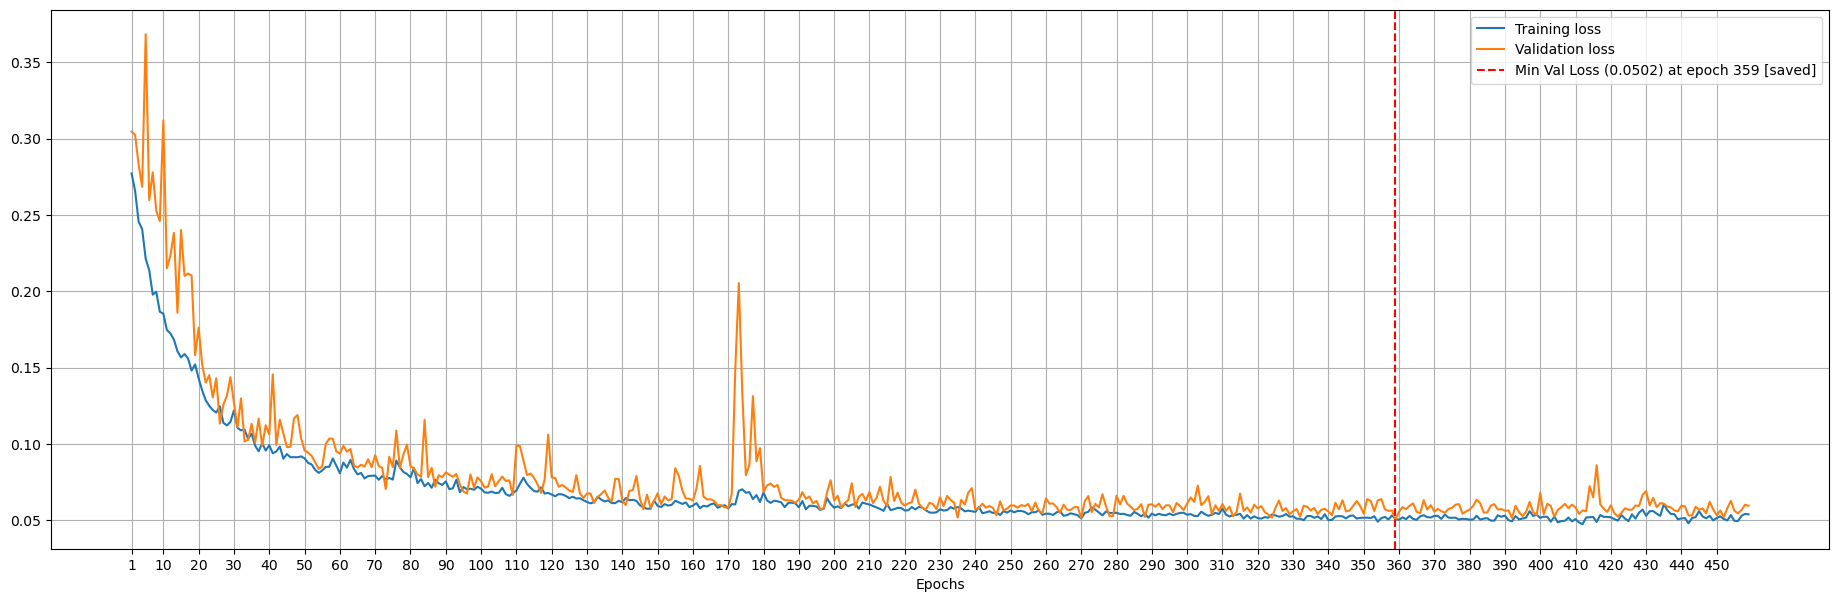

In [17]:
epochs_trained = len(history['train_loss'])
fig = plt.figure(figsize=(max(10, 0.05 * epochs_trained), 7))
plt.plot(np.arange(1, epochs_trained+1), history['train_loss'], label='Training loss')
plt.plot(np.arange(1, epochs_trained+1), history['val_loss'], label='Validation loss')

min_val_loss = min(history['val_loss'])
min_val_loss_epoch = history['val_loss'].index(min_val_loss) +1
plt.axvline(x=min_val_loss_epoch, color='red', linestyle='--', label=f'Min Val Loss ({min_val_loss:.4f}) at epoch {min_val_loss_epoch} [saved]')

interval=10
ticks = [1] + list(range(interval, epochs_trained + 1, interval))   #start in 1, go 1, 10, 20, 30...
plt.xticks(ticks)
#fig.autofmt_xdate()

plt.xlabel("Epochs")
plt.grid(True)
plt.legend()
plt.show()

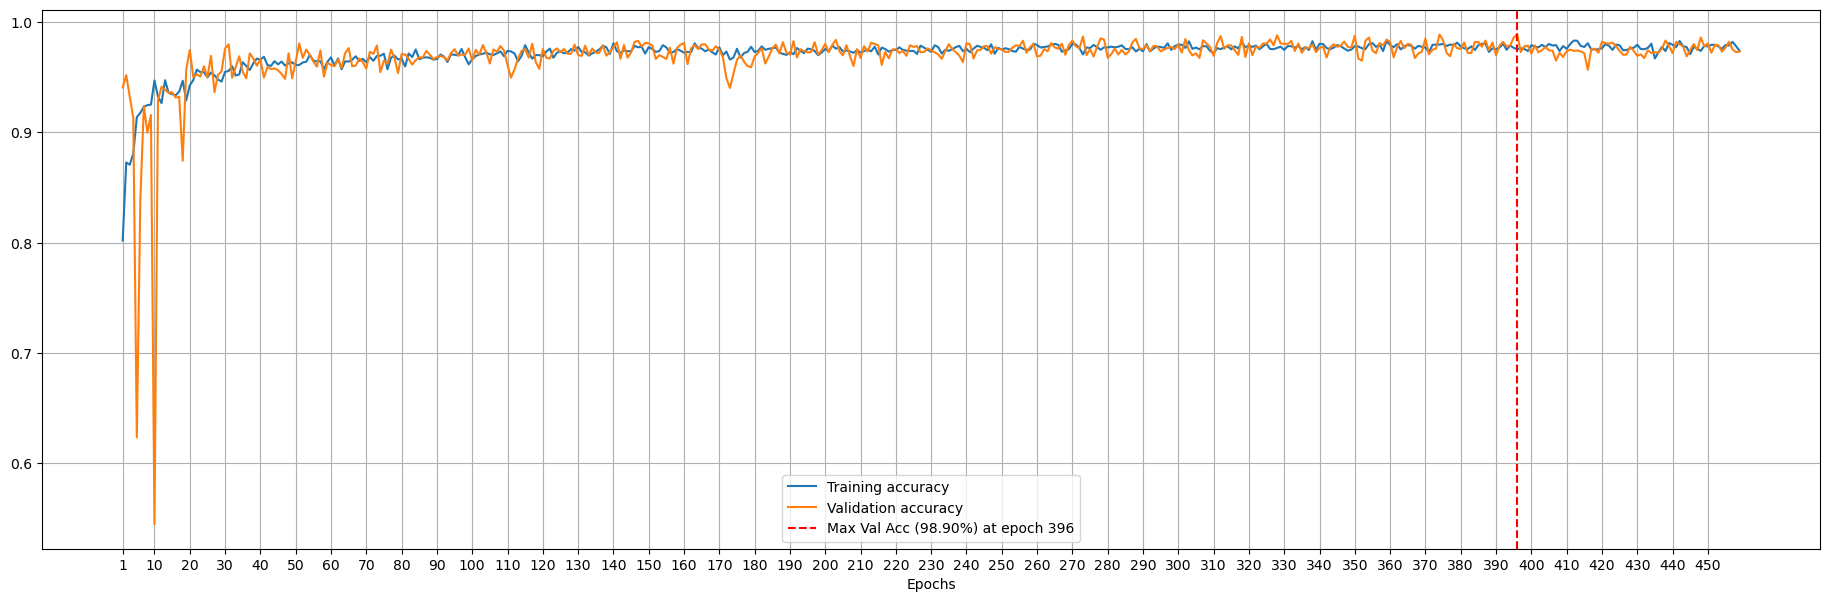

In [18]:
# from tensor to numpy
train_accuracy_cpu = [acc.cpu().numpy()/100 for acc in history['train_accuracy']]
val_accuracy_cpu = [acc.cpu().numpy()/100 for acc in history['val_accuracy']]
#print(train_accuracy_cpu)

fig = plt.figure(figsize=(max(10, 0.05 * epochs_trained), 7))
plt.plot(np.arange(1,epochs_trained+1), train_accuracy_cpu, label='Training accuracy')
plt.plot(np.arange(1,epochs_trained+1), val_accuracy_cpu, label='Validation accuracy')

max_val_acc = max(history['val_accuracy'])
max_val_acc_epoch = history['val_accuracy'].index(max_val_acc) +1
plt.axvline(x=max_val_acc_epoch, color='red', linestyle='--', label=f'Max Val Acc ({max_val_acc:.2f}%) at epoch {max_val_acc_epoch}')

interval=10
ticks = [1] + list(range(interval, epochs_trained + 1, interval))   #start in 1, go 1, 10, 20, 30...
plt.xticks(ticks)

#fig.autofmt_xdate()
plt.xlabel("Epochs")
plt.grid()
plt.legend()
plt.show()

**TEST**

In [19]:
# create model and load saved state 
# #model = UNet(n_channels=NUM_CHANNELS_IN, n_classes=NUM_CHANNELS_OUT)
# load_model_path = './trained_models/20250126_214831_UNet_0.06924
# model.load_state_dict(torch.load(load_model_path))
model.to(device)
model.eval()     # !!! set the dropout and batch normalization layers to evaluation mode

UNet(
  (inp): InputBlock(
    (conv): Block(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): EncoderBlock(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Block(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (4): BatchNorm2d(128, e

In [20]:
test_transform = transforms.Compose([
    transforms.Resize((512, 512)),  # evaluation at native resolution
    # v2.RandomRotation(degrees=(-180, 180)),
    # v2.RandomHorizontalFlip(),
    # v2.RandomVerticalFlip(),
    # v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
    # v2.GaussianNoise(),
    # v2.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 1)),
    #transforms.ToTensor(),    # already tensor
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])

# load test images
test_img_dir = './data/CHASE/test/images'
test_gt_dir = './data/CHASE/test/1st_manual'

test_dataset = Dataset(test_img_dir, test_gt_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [21]:
#check test image
for img, gt, img_name in test_loader:
    print(f"Shape of image: {img.shape}")
    print(f"Shape of GT: {gt.shape}")
    print(f"Name of image: {img_name[0]}") 
    break  # just one

Shape of image: torch.Size([1, 3, 512, 512])
Shape of GT: torch.Size([1, 1, 512, 512])
Name of image: 01_test.tif


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].


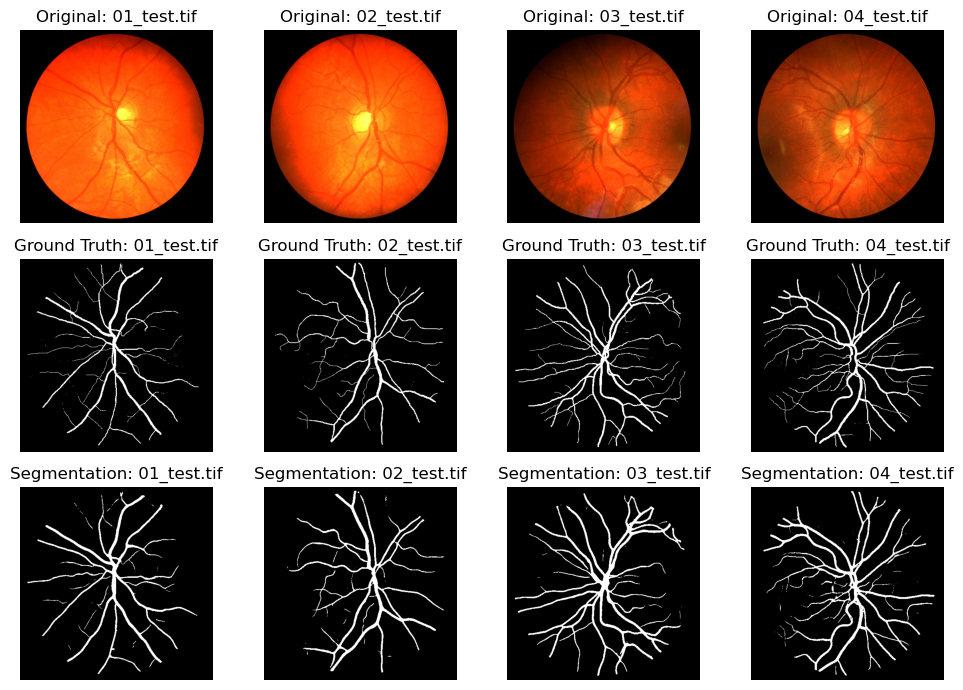

In [22]:
model.eval()   # done before, but just in case...

num_images = 4  # number of images to show
fig, axes = plt.subplots(3, num_images, figsize=(10, 7))

i = 0  # counter

with torch.no_grad():  # no gradient needed
    for image, gt, image_name in test_loader:
        if i >= num_images: 
            break

        # move to cuda
        image = image.to(device)

        output = model(image)  # predict
        output_binary = (output > 0.5).float()  # convert to 0 or 1

        # convert output to image
        output_img = output_binary.squeeze().cpu().numpy()  # delete batch dimension
        gt_img = gt.squeeze().cpu().numpy()

        # original test images
        axes[0, i].imshow(image.squeeze().cpu().numpy().transpose(1, 2, 0))  # from tensor to image
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Original: {image_name[0]}")
        
        # test images ground truth segmentations
        axes[1, i].imshow(gt_img, cmap='gray')  # grayscale
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Ground Truth: {image_name[0]}")

        # test images predicted segmentations
        axes[2, i].imshow(output_img, cmap='gray')  # grayscale
        axes[2, i].axis('off')
        axes[2, i].set_title(f"Segmentation: {image_name[0]}")

        i += 1

plt.tight_layout()
plt.show()

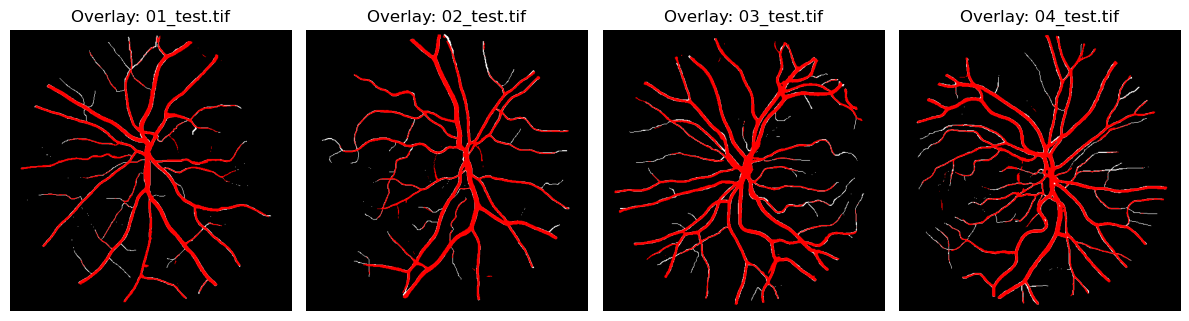

In [23]:
model.eval()   # done before, but just in case...

num_images = 4   # number of images to show
fig, axes = plt.subplots(1, num_images, figsize=(12, 8))

i = 0  # counter

with torch.no_grad():  # no gradient needed
    for image, gt, image_name in test_loader:
        if i >= num_images: 
            break

        # move to CUDA
        image = image.to(device)

        output = model(image)  # predict
        output_binary = (output > 0.5).float()  # binarize prediction

        # convert prediction to image
        output_img = output_binary.squeeze().cpu().numpy()  # delete batch dimension
        gt_img = gt.squeeze().cpu().numpy()  # gt as image

        # Mostrar ground truth como fondo en escala de grises
        axes[i].imshow(gt_img, cmap='gray')  # Fondo: ground truth
        
        # Crear imagen RGBA para superponer
        overlay = np.zeros((*output_img.shape, 4))  # Crear un mapa RGBA
        overlay[..., 0] = 1  # Canal rojo
        overlay[..., 3] = output_img  # Canal alfa (0 para transparente, 1 para opaco)
        
        axes[i].imshow(overlay)  # Superposición en RGBA
        
        axes[i].axis('off')
        axes[i].set_title(f"Overlay: {image_name[0]}")

        i += 1

plt.tight_layout()
plt.show()

**ROC, AUC, Test Accuracy, Dice score, MCC, ccDice**


Dice score: 0.7962

MCC: 0.7851

ccDice score: 0.0956

Test Accuracy: 0.9722

F1 Score: 0.7964




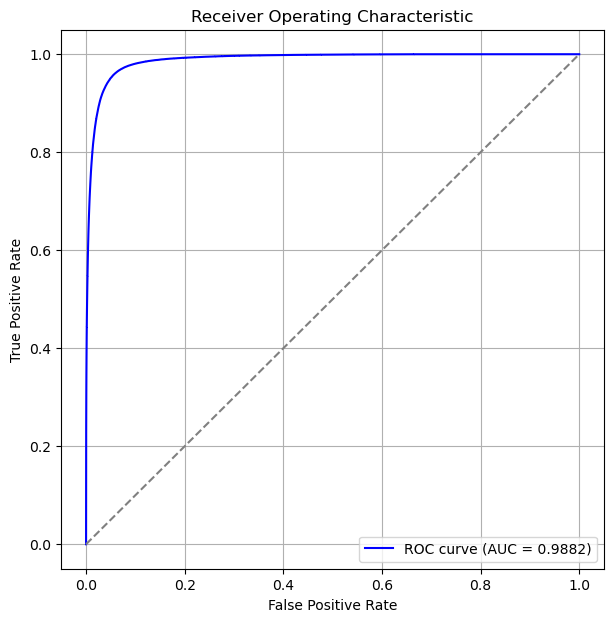

In [24]:
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score
from utils.dice_score import dice_score                     # custom function to calculate dice score
from utils.matthews_corr_coef import matthews_corr_coef     # custom function to calculate MCC
from utils.ccDice_score import ccDice                       # modified ccDice score (only binary labels)
from skimage.measure import label                           # necessary for ccDice

calculate_ccdice = True    # yes or no. Forced to use CPU: it takes long to compute (5 minutes just 8 images)

all_labels = []       # to store ground truth values for each pixel of each image
all_preds = []        # to store predicted values for each pixel of each image

dice_score_batches = []       # to store Dice score of each batch
mcc_batches = []              # to store MCC of each batch
if calculate_ccdice==True:
    ccdice_score_batches = []     # to store ccDice score of each batch

with torch.no_grad():  # no gradients needed
    for inputs, ground_truth, _ in test_loader:        # for each batch in test loader
        inputs = inputs.to(device)
        ground_truth = ground_truth.to(device)

        outputs = model(inputs)     # predict

        all_labels.append(ground_truth.cpu().numpy())       # real labels for each pixel (0 or 1) 
        all_preds.append(outputs.cpu().numpy())             # probabilities to belong to class 1, given by model
        
        dice = dice_score(outputs, ground_truth, threshold=0.5)
        dice_score_batches.append(dice.item())
        
        mcc = matthews_corr_coef(outputs, ground_truth, threshold=0.5)
        mcc_batches.append(mcc)

        if calculate_ccdice==True:
            y_pred_label, cc_pred = label(((outputs > 0.5).float()).cpu().numpy().squeeze(0), return_num=True)
            y_true_label, cc_true = label(ground_truth.cpu().numpy().squeeze(0), return_num=True)
            ccdice = ccDice(y_pred_label, cc_pred, y_true_label, cc_true, alpha=0.1)    # alpha is level of exigency to join 2 cc (low is permissive, 1.0 is max exigency)
            ccdice_score_batches.append(ccdice)

# compute mean dice score and print
mean_dice_score = torch.tensor(dice_score_batches).mean()
print(f"\nDice score: {mean_dice_score:.4f}")

# compute mean MCC and print
mean_mcc = torch.tensor(mcc_batches).mean()
print(f"\nMCC: {mean_mcc:.4f}")

# compute mean ccDice score and print
if calculate_ccdice==True:
    mean_ccdice_score = torch.tensor(ccdice_score_batches).mean()
    print(f"\nccDice score: {mean_ccdice_score:.4f}")

# list to numpy array
all_labels = np.concatenate(all_labels, axis=0)
all_preds = np.concatenate(all_preds, axis=0)

# compute mean test accuracy and print
accuracy_sklearn = accuracy_score(list(map(bool,all_labels.flatten())), (all_preds.flatten() > 0.5))
print(f"\nTest Accuracy: {accuracy_sklearn:.4f}")

# compute mean F1 score accuracy and print
f1_sklearn = f1_score(list(map(bool,all_labels.flatten())), (all_preds.flatten() > 0.5))
print(f"\nF1 Score: {f1_sklearn:.4f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(list(map(bool,all_labels.flatten())), all_preds.flatten())     # force labels to binary list (if not, error when transform.resize)

# AUC
roc_auc = auc(fpr, tpr)

# plot ROC
print("\n")
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

trained_models\20250206_013656_UNet_0.05018

In [25]:
# just to visualize the model architecture

'''from torch.utils.tensorboard import SummaryWriter
import torchvision

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/UNet')

# get some random training images
dataiter = iter(train_loader)
images, labels, _ = next(dataiter)

print(images.shape)
images = images.to(device)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

#img_grid = img_grid.unsqueeze(0) 

# write to tensorboard
writer.add_image('train_img', img_grid)

writer.add_graph(model, images)
writer.close()

# write in terminal --->   tensorboard --logdir=runs/Unet'''

'from torch.utils.tensorboard import SummaryWriter\nimport torchvision\n\n# default `log_dir` is "runs" - we\'ll be more specific here\nwriter = SummaryWriter(\'runs/UNet\')\n\n# get some random training images\ndataiter = iter(train_loader)\nimages, labels, _ = next(dataiter)\n\nprint(images.shape)\nimages = images.to(device)\n\n# create grid of images\nimg_grid = torchvision.utils.make_grid(images)\n\n#img_grid = img_grid.unsqueeze(0) \n\n# write to tensorboard\nwriter.add_image(\'train_img\', img_grid)\n\nwriter.add_graph(model, images)\nwriter.close()\n\n# write in terminal --->   tensorboard --logdir=runs/Unet'